<div class="alert alert-success">
<h1>TABLE OF CONTENTS</h1>
</div>

* [Notes](#NOTES)
* [Setup](#SETUP)
* [Modeling Functions](#MODELING-FUNCTIONS)
* [Logistic Regression](#LOGISTIC-REGRESSION)
* [KNN](#KNN)
* [Random Forests](#RANDOM-FORESTS)
* [SVC](#SVC)
* [Clustering](#CLUSTERING)
* [DBSCAN](#DBSCAN)

<div class="alert alert-success">
<h1>NOTES</h1>
</div>

There are 3 sets of columns:

* **sec_cols**: security incident columns (outcome variables)
    * values = -1 (no), 1 (yes), and 0 (NA)
* **dem_cols**: demographic info columns (predictor variables)
* **hab_cols**: security habit columns (predictor variables)

<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data

In [2]:
df = pd.read_csv('cybersecurity_clean_31Jul17.txt', sep = '\t', encoding = 'utf8')

## Create age groups

In [3]:
for i in range(0,len(df.age)):
    j = df.loc[i,'age']
    if(j >= 1) & (j <= 20): df.loc[i,'age_group'] = '1-20'
    elif(j >= 21) & (j <= 30): df.loc[i,'age_group'] = '21-30'
    elif(j >= 31) & (j <= 40): df.loc[i,'age_group'] = '31-40'
    elif(j >= 41) & (j <= 50): df.loc[i,'age_group'] = '41-50'
    elif(j >= 51) & (j <= 60): df.loc[i,'age_group'] = '51-60'
    elif(j >= 61) & (j <= 70): df.loc[i,'age_group'] = '61-70'
    elif(j >= 71) & (j <= 80): df.loc[i,'age_group'] = '71-80'
    elif(j >= 81): df.loc[i,'age_group'] = '81+'
    else: df.loc[i,'age_group'] = 'other'

## Create income groups

In [4]:
for i in range(0,len(df.inc)):
    j = df.loc[i,'inc']
    if(j == 1): df.loc[i,'inc_group'] = '$0-\n10,000'
    elif(j == 2): df.loc[i,'inc_group'] = '$10,000-\n19,999'
    elif(j == 3): df.loc[i,'inc_group'] = '$20,000-\n29,999'
    elif(j == 4): df.loc[i,'inc_group'] = '$30,000-\n39,999'
    elif(j == 5): df.loc[i,'inc_group'] = '$40,000-\n49,999'
    elif(j == 6): df.loc[i,'inc_group'] = '$50,000-\n59,999'
    elif(j == 7): df.loc[i,'inc_group'] = '$75,000-\n99,999'
    elif(j == 8): df.loc[i,'inc_group'] = '$100,000-\n149,999'
    elif(j == 9): df.loc[i,'inc_group'] = '$150,000+'
    else: df.loc[i,'inc_group'] = 'Other'

## Create subset dataframes

In [5]:
sec_cols = [s for s in df.columns if (s.lower().strip().startswith('sec')) |
           (s == 'ID') and
           (s != 'secur1')]
df_sec = df[sec_cols]

print('Security incident variables: ', sec_cols)

Security incident variables:  ['ID', 'secur2a', 'secur2b', 'secur2c', 'secur2d', 'secur2e', 'secur2f', 'secur2g']


In [6]:
exclude = ['habits4a', 'habits4b', 'habits1f', 'habits1fos', 'habits9os', 'habits1cnt']
hab_cols = [s for s in df.columns if (s.lower().strip().startswith('hab')) |
           (s == 'ID') |
           (s.lower().strip().startswith('wifi2')) and 
           (s not in exclude)]
df_hab = df[hab_cols]

print('Security habit variables: ', hab_cols)

Security habit variables:  ['ID', 'habits1a', 'habits1b', 'habits1c', 'habits1d', 'habits1e', 'habits2', 'habits3', 'habits4c', 'habits5', 'habits6', 'habits7', 'habits8', 'habits9', 'habits10', 'habits11', 'habits12', 'wifi2a', 'wifi2b', 'wifi2c', 'wifi2d']


In [7]:
temp = ['sex','age','educ2','hisp','race3m1','marital',
        'par','emplnw3','party','partyln','ideo','inc',
        'usr']
dem_cols = [s for s in df.columns if (s in temp) |
            (s == 'ID')]
df_dem = df[dem_cols]

print('Demographic variables: ', dem_cols)

Demographic variables:  ['ID', 'sex', 'age', 'educ2', 'hisp', 'race3m1', 'marital', 'par', 'emplnw3', 'party', 'partyln', 'ideo', 'inc', 'usr']


## Create dictionary of columns

In [8]:
dict_sec_cols = {'secur2a': 'SSN compromised',
                 'secur2b': 'Other sensitive info compromised',
                 'secur2c': 'Fraudulent charges on credit/debit card',
                 'secur2d': 'Someone took over email',
                 'secur2e': 'Someone took over social media account',
                 'secur2f': 'Someone opened line of credit/applied for loan under name',
                 'secur2g': 'Someone received tax refund under name'}

for key, val in dict_sec_cols.items():
    print(key,val)

secur2a SSN compromised
secur2b Other sensitive info compromised
secur2c Fraudulent charges on credit/debit card
secur2d Someone took over email
secur2e Someone took over social media account
secur2f Someone opened line of credit/applied for loan under name
secur2g Someone received tax refund under name


# Correlations

## Security incident variables

In [9]:
df_sec.corr()

,ID,secur2a,secur2b,secur2c,secur2d,secur2e,secur2f,secur2g
ID,1.000000,0.072080,0.040866,0.072952,0.104097,0.025571,0.000368,0.000181
secur2a,0.072080,1.000000,0.313427,0.184122,0.143392,0.049244,0.261746,0.214680
secur2b,0.040866,0.313427,1.000000,0.332780,0.210134,-0.005351,0.226394,0.050177
secur2c,0.072952,0.184122,0.332780,1.000000,0.187828,0.005934,0.197522,0.067478
secur2d,0.104097,0.143392,0.210134,0.187828,1.000000,0.161101,0.159210,0.071669
secur2e,0.025571,0.049244,-0.005351,0.005934,0.161101,1.000000,0.071255,0.077058
secur2f,0.000368,0.261746,0.226394,0.197522,0.159210,0.071255,1.000000,0.167113
secur2g,0.000181,0.214680,0.050177,0.067478,0.071669,0.077058,0.167113,1.000000


## Security habit variables

In [10]:
df_hab.corr()

,ID,habits1a,habits1b,habits1c,habits1d,habits1e,habits2,habits3,habits4c,habits5,...,habits7,habits8,habits9,habits10,habits11,habits12,wifi2a,wifi2b,wifi2c,wifi2d
ID,1.000000,0.183073,0.040823,0.110087,0.113262,0.136921,0.138584,0.139372,0.042008,0.064479,...,0.088516,0.151842,0.196000,0.157131,0.167480,0.024132,0.018453,0.004635,0.127739,0.132822
habits1a,0.183073,1.000000,0.055674,0.094748,0.088844,0.128422,0.238986,0.510972,0.095607,0.208840,...,-0.024552,0.202567,0.181217,0.197469,0.233134,0.070714,-0.217492,-0.224720,0.012738,0.029241
habits1b,0.040823,0.055674,1.000000,-0.051519,0.081297,0.067287,0.326063,0.259651,0.194989,0.127481,...,-0.096776,0.018599,0.013333,0.143170,0.122541,-0.005790,-0.110265,-0.194280,-0.100717,-0.052179
habits1c,0.110087,0.094748,-0.051519,1.000000,0.122601,0.202593,0.296074,0.113560,0.116470,0.136122,...,0.211228,0.210087,0.206472,0.028803,0.038755,0.012985,0.119003,-0.025907,0.180584,0.200469
habits1d,0.113262,0.088844,0.081297,0.122601,1.000000,0.262554,0.500973,0.115101,0.222221,0.143687,...,0.059604,0.181439,0.161058,0.113946,0.138885,-0.035652,0.037129,0.027421,0.080417,0.143080
habits1e,0.136921,0.128422,0.067287,0.202593,0.262554,1.000000,0.377690,0.055410,0.177683,0.203903,...,0.137085,0.146539,0.123842,0.054136,0.103644,0.000722,0.076992,0.024533,0.128029,0.193178
habits2,0.138584,0.238986,0.326063,0.296074,0.500973,0.377690,1.000000,0.220547,0.267822,0.148345,...,0.063957,0.197127,0.162676,0.113223,0.140825,0.001747,0.021864,-0.052551,0.050082,0.151428
habits3,0.139372,0.510972,0.259651,0.113560,0.115101,0.055410,0.220547,1.000000,0.057213,0.170201,...,-0.182065,0.237070,0.248696,0.271845,0.258158,0.102834,-0.398896,-0.392012,-0.173753,-0.158589
habits4c,0.042008,0.095607,0.194989,0.116470,0.222221,0.177683,0.267822,0.057213,1.000000,0.161064,...,0.044074,0.062927,0.026525,0.117245,0.162461,-0.052224,0.102532,0.039616,0.135923,0.208694
habits5,0.064479,0.208840,0.127481,0.136122,0.143687,0.203903,0.148345,0.170201,0.161064,1.000000,...,0.194327,0.146339,0.157304,0.129403,0.172596,0.003689,0.079722,0.074462,0.226470,0.253709


## Demographic variables

In [11]:
df_dem.corr()

,ID,sex,age,educ2,hisp,race3m1,marital,par,emplnw3,party,partyln,ideo,inc,usr
ID,1.000000,-0.119406,-0.343113,-0.010926,0.103976,0.112147,0.027175,0.106426,-0.204131,-0.005242,0.040151,0.059691,-0.111167,0.113990
sex,-0.119406,1.000000,0.100085,-0.032790,-0.002374,0.048729,-0.003834,-0.013111,0.221449,-0.049019,-0.093035,0.053488,0.005074,-0.043298
age,-0.343113,0.100085,1.000000,0.163559,-0.127582,-0.177774,-0.256278,-0.268125,0.250020,-0.088816,-0.123027,-0.120902,0.211119,-0.091053
educ2,-0.010926,-0.032790,0.163559,1.000000,0.026655,-0.050589,-0.072269,0.004125,-0.018757,-0.053825,-0.026698,-0.092463,0.155940,-0.038071
hisp,0.103976,-0.002374,-0.127582,0.026655,1.000000,0.487058,0.076618,0.127328,-0.023787,0.024166,0.034256,-0.041843,0.016345,0.055148
race3m1,0.112147,0.048729,-0.177774,-0.050589,0.487058,1.000000,0.108447,0.119486,0.032119,0.092149,0.107876,0.029285,-0.082905,0.061872
marital,0.027175,-0.003834,-0.256278,-0.072269,0.076618,0.108447,1.000000,-0.240432,0.144174,0.084820,-0.002562,0.122642,-0.015750,0.058423
par,0.106426,-0.013111,-0.268125,0.004125,0.127328,0.119486,-0.240432,1.000000,-0.224839,0.033337,0.036833,-0.089019,-0.067813,-0.042455
emplnw3,-0.204131,0.221449,0.250020,-0.018757,-0.023787,0.032119,0.144174,-0.224839,1.000000,0.050664,-0.042718,0.010396,0.044492,-0.092209
party,-0.005242,-0.049019,-0.088816,-0.053825,0.024166,0.092149,0.084820,0.033337,0.050664,1.000000,0.461573,0.168174,-0.002514,0.045377


## Security incident variables x Demographic variables

In [12]:
# Function to calculate correlations between columns in two dataframes

def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n,
                        df2.columns, df1.columns)

In [13]:
corr(df_dem, df_sec)

,ID,sex,age,educ2,hisp,race3m1,marital,par,emplnw3,party,partyln,ideo,inc,usr
ID,1.000000,-0.119406,-0.343113,-0.010926,0.103976,0.112147,0.027175,0.106426,-0.204131,-0.005242,0.040151,0.059691,-0.111167,0.113990
secur2a,0.072080,-0.030320,-0.035065,-0.008632,0.025851,0.014530,-0.104695,0.079287,-0.089091,0.028590,0.035654,0.023675,-0.022383,0.021950
secur2b,0.040866,0.004734,0.003588,-0.031545,-0.057366,-0.106956,-0.154279,0.055819,-0.119232,-0.007301,-0.027898,0.063029,-0.038112,0.050394
secur2c,0.072952,-0.046588,0.002489,0.003524,-0.090925,-0.118831,-0.203682,0.044959,-0.166174,-0.039088,0.072154,0.051133,-0.002749,0.080112
secur2d,0.104097,-0.002071,-0.147863,-0.039613,0.023180,-0.006598,-0.024650,0.125619,-0.144305,0.011587,0.038981,0.060056,-0.050390,0.017205
secur2e,0.025571,0.066730,-0.038598,-0.014350,0.067735,0.043507,0.135979,-0.055915,0.062612,-0.021987,-0.027047,0.021751,-0.025550,-0.018430
secur2f,0.000368,0.007001,0.028736,-0.028114,0.048383,0.036955,-0.043536,0.026722,-0.007297,0.002093,0.010621,0.003048,0.013215,0.015216
secur2g,0.000181,0.033695,0.058045,0.001262,0.036077,0.008052,0.006507,-0.017757,0.039903,-0.021220,-0.000901,0.013184,-0.013529,-0.003001


## Security incident variables x Security habit variables

In [14]:
corr(df_hab, df_sec)

,ID,habits1a,habits1b,habits1c,habits1d,habits1e,habits2,habits3,habits4c,habits5,...,habits7,habits8,habits9,habits10,habits11,habits12,wifi2a,wifi2b,wifi2c,wifi2d
ID,1.000000,0.183073,0.040823,0.110087,0.113262,0.136921,0.138584,0.139372,0.042008,0.064479,...,0.088516,0.151842,0.196000,0.157131,0.167480,0.024132,0.018453,0.004635,0.127739,0.132822
secur2a,0.072080,0.014996,0.024304,0.079987,0.007166,0.000794,0.050720,0.048192,0.069716,0.069366,...,0.014839,0.097182,0.107420,0.088302,0.079532,0.062710,0.003550,-0.007899,0.016219,0.065232
secur2b,0.040866,0.079479,0.062333,0.056242,0.084433,0.031960,0.125076,0.110201,0.146549,0.141250,...,0.018873,0.098475,0.080589,0.090738,0.062301,0.085787,0.023264,0.001006,0.065446,0.109405
secur2c,0.072952,0.085183,0.074544,0.093321,0.074937,0.054730,0.113237,0.140331,0.135357,0.116328,...,0.051354,0.136347,0.113375,0.093041,0.123850,0.019965,0.023707,-0.028231,0.063653,0.113082
secur2d,0.104097,0.141824,0.051424,0.100096,0.095092,0.142836,0.113582,0.140649,0.122851,0.121390,...,0.068926,0.120652,0.136967,0.060746,0.051788,0.074566,-0.000928,-0.036413,0.060873,0.052463
secur2e,0.025571,-0.184295,-0.100139,0.003569,0.038374,0.014606,-0.020672,-0.281991,-0.005471,-0.033966,...,0.211011,-0.018368,0.026638,-0.139129,-0.105102,0.048604,0.163846,0.153177,0.138271,0.039319
secur2f,0.000368,-0.048391,-0.025437,-0.019109,0.016545,0.013228,0.047447,-0.006194,0.045859,-0.043040,...,-0.013140,-0.010075,0.018298,0.029252,-0.012681,0.063624,0.053571,0.025124,-0.029764,0.004025
secur2g,0.000181,-0.061285,0.033503,0.008841,-0.002233,0.013687,-0.018018,-0.078129,0.013064,-0.034826,...,-0.012401,-0.071232,-0.055527,-0.024432,-0.046423,0.017813,-0.004281,-0.016321,-0.027180,-0.038973


<div class="alert alert-success">
<h1>MODELING FUNCTIONS</h1>
</div>

### Function: cv_optimize (cross-validation)
**Input**
- Classifier ('clf')
- Grid of hyperparameters implemented as a dictionary ('parameters')
- Training set, as a samples x features array ('XTrain')
- Set of labels ('ytrain)

**Function**

Takes the training set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each fold for us

**Output**
- Prints the best value of the parameters
- Returns the best classifier ('best')

In [15]:
from sklearn.model_selection import GridSearchCV

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds, scorer):

    gs = GridSearchCV(clf,
                      param_grid = parameters,
                      cv = n_folds,
                      scoring = scorer)

    gs.fit(Xtrain, ytrain)
    print('\tBest Parameters: ' + str(gs.best_params_))
    print('\tScoring method used: ' + str(gs.scorer_) + ')')
    
    return gs.best_estimator_, gs.best_params_

### do_classify
**Input**
- Classifier ('clf')
- Parameters, such as regularization parameter ('parameters')
- Dataframe containing features and target ('in_df')
- List of columns to use as features ('feature_names')
- Column to use as target ('targetname')
- Value to use as target - will be set to 1; all others will be set to 0 ('targetlval')
- Boolean to indicate whether to standardize data ('standardize')
- Boolean to indicate whether to use stratified sampling for cross-validation ('strat')

**Function**
- Splits dataframe into 75% training and 25% test
- Standardizes the dataset if desired (scales the data so that it has a mean of 0 and is described in units of its SD)
- Trains model on training set using cross-validation
- Uses cv_optimize to obtain best classifier and then re-trains on entire training set

**Output**
- Returns split data and trained classifier

In [16]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, df, feature_names, targetname, target1val, standardize, scorer, strat, mod_results, clf_str):
    
    n_folds = 5
    
    """Create X and y"""
    
    sub_df = df[feature_names]
    
    if standardize:
        sub_df_std = (sub_df - sub_df.mean())/sub_df.std()
    else:
        sub_df_std = sub_df
    
    # X = df with feature columns
    X = sub_df_std.values
    
    #if clf == LogisticRegression:
    if clf_str == 'logreg':
        # y = array with 1 when value in target column matches targetlval, and 0 when it doesn't
        y = (df[targetname].values == target1val)*1
    else:
        y = df[targetname]
        
    classes = df[targetname].unique()
        
    """Create training and test sets"""
    
    if strat == True:
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)
    else:
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
    
    unique, counts = np.unique(ytrain, return_counts=True)
    print('\tClasses in ytrain: ' + str(dict(zip(unique, counts))))
    
    unique, counts = np.unique(ytest, return_counts=True)
    print('\tClasses in ytest: ' + str(dict(zip(unique, counts))))
        
    """Create and fit model"""
    
    clf, best_params = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds, scorer)
    clf = clf.fit(Xtrain, ytrain)

    """Evaluate model"""
    
    if x_cols[0] == 'sex':
        Xname = 'dem_vars'
    elif x_cols[0] == 'habits1a':
        Xname = 'hab_cols'
    else:
        Xname = 'unknown'
    
    # with train data:
    acc_train, acc_test, precision_train, recall_train, f1_train, cohenk_train = model_eval(clf,
                                                                                            Xtrain,
                                                                                            Xtest,
                                                                                            ytrain,
                                                                                            ytest,
                                                                                            feature_names,
                                                                                            classes,
                                                                                            'train')
    
    # with test data:
    acc_train, acc_test, precision_test, recall_test, f1_test, cohenk_test = model_eval(clf,
                                                                                        Xtrain,
                                                                                        Xtest,
                                                                                        ytrain,
                                                                                        ytest,
                                                                                        feature_names,
                                                                                        classes,
                                                                                        'test')
    
    """Save results of model eval"""  
    mod_results = model_results(clf_str,
                                targetname,
                                Xname,
                                scorer,
                                best_params,
                                acc_train,
                                acc_test,
                                precision_train,
                                recall_train,
                                f1_train,
                                cohenk_train,
                                precision_test,
                                recall_test,
                                f1_test,
                                cohenk_test,
                                mod_results)
    
    return clf, Xtrain, ytrain, Xtest, ytest, mod_results

### Plot confusion matrix
Prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

In [17]:
import itertools

def plot_confusion_matrix(cm, classes, normalize, cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Calculate proportion in classes
Given a dataframe and column, prints number of observations per class in column and proportion of total observations

In [18]:
def calc_prop_class(df, col):
    classes = df[col].unique()
    for c in classes:
        num_obs = sum(df[col] == c)
        total_obs = len(df[col])
        prop = round(100*(num_obs / total_obs),2)
        print('\tObservations in class ' + str(c) + ': ' + str(num_obs) + ' (' + str(prop) + '%)')    

### Perform model evaluation
Calculates and prints precision, recall, F1-score, cohen's kappa, feature importance, and confusion matrix

In [19]:
from sklearn import metrics

def model_eval(clf, Xtrain, Xtest, ytrain, ytest, feature_names, classes, test_or_train):
    
    """ ======= CALCULATE TRAINING AND TEST ACCURACY ======= """
    
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print('\tAccuracy on training data: {:0.2f}'.format(training_accuracy))
    print('\tAccuracy on test data:     {:0.2f}'.format(test_accuracy))
        
    """ ======= CALCULATE PRECISION, RECALL, F1-SCORE, AND COHEN'S KAPPA ======= """

    if test_or_train == 'test':
        ypred = clf.predict(Xtest)
        ytrue = ytest
        print('\tMetrics for test data')
    else:
        ypred = clf.predict(Xtrain)
        ytrue = ytrain
        print('\tMetrics for train data')
    
    # set average method for metrics
    if len(classes) == 2:
        average_param = 'binary'
    else:
        average_param = 'weighted'
    
    precision = metrics.precision_score(ytrue, ypred, average=average_param)
    
    recall = metrics.recall_score(ytrue, ypred, average=average_param)
    
    f1 = metrics.f1_score(ytrue, ypred, average=average_param)
    
    cohenk = metrics.cohen_kappa_score(ytrue, ypred)
    
    print('\tPrecision: ' + str(round(precision,2)))
    print('\tRecall: ' + str(round(recall,2))) 
    print('\tF1 Score: ' + str(round(f1,2)))
    print('\tCohen\'s Kappa: ' + str(round(cohenk,2)))
    
    """ ======= GRAPH FEATURE IMPORTANCE ======= """
    
    if hasattr(clf, 'feature_importances_'):
        graph_feature_import(clf, feature_names, Xtrain, 'feat_imp')
    elif hasattr(clf, 'coef_'):
        graph_feature_import(clf, feature_names, Xtrain, 'coef')

    """ ======= CREATE CONFUSION MATRIX ======= """
    
    cnf_matrix = metrics.confusion_matrix(ytrue, ypred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes, False)
    plt.show()
    
    return training_accuracy, test_accuracy, precision, recall, f1, cohenk

### Store results in dataframe

In [20]:
def model_results(clf_str, yname, Xname, scorer, best_params, acc_train, acc_test,
                  precision_train, recall_train, f1_train, cohenk_train,
                  precision_test, recall_test, f1_test, cohenk_test, mod_results):
    
    if str(scorer) == 'make_scorer(cohen_kappa_score)':
        scorer_str = 'cohenk'
    else:
        scorer_str = str(scorer)
    
    dict_metrics = {}
    dict_metrics['clf'] = clf_str
    dict_metrics['y'] = yname
    dict_metrics['X'] = Xname
    dict_metrics['score_meth'] = scorer_str
    dict_metrics['best_params'] = best_params
    dict_metrics['acc_train'] = round(acc_train,2)
    dict_metrics['acc_test'] = round(acc_test,2)
    dict_metrics['precision_train'] = round(precision_train,2)
    dict_metrics['recall_train'] = round(recall_train,2)
    dict_metrics['f1_train'] = round(f1_train,2)
    dict_metrics['cohenk_train'] = round(cohenk_train,2)
    dict_metrics['precision_test'] = round(precision_test,2)
    dict_metrics['recall_test'] = round(recall_test,2)
    dict_metrics['f1_test'] = round(f1_test,2)
    dict_metrics['cohenk_test'] = round(cohenk_test,2)

    mod_results.append(dict_metrics)
    
    return mod_results

### Plot feature importance
Plots the clf feature importances

In [21]:
def graph_feature_import(clf, features, Xtrain, graph_type):
        
    if graph_type == 'feat_imp':
        
        df_graph = pd.DataFrame(clf.feature_importances_,
                                index=features, 
                                columns=['Importance'])

        df_graph['Std'] = np.std([clf.feature_importances_
                                for est in clf.estimators_], axis=0)

        x = range(df_graph.shape[0])
        y = df_graph.ix[:, 0]
        yerr = df_graph.ix[:, 1]
        
        plt.bar(x, y, yerr=yerr, align='center')
        plt.xticks(np.arange(min(x), max(x)+1, 1))    
        plt.xticks(x, features, rotation='vertical')
        plt.title('Feature importance')
        
        plt.show()

    elif graph_type == 'coef':
        
        coefs = np.std(Xtrain, 0)*clf.coef_
        coefs = pd.Series(coefs[0])
        
        df_graph = pd.DataFrame({'Feature': features,
                                 'Coefficient': coefs,
                                 'Coeff_AV': abs(coefs)})

        # sort dataframe by absolute value of coefficients
        df_graph = df_graph.sort_values(by = 'Coeff_AV', ascending = False)
        
        print('\t\nStandardized coefficients\n')
        print(df_graph)
        
        # sort dataframe by absolute value of coefficients
        df_graph = df_graph.sort_values(by = 'Coefficient', ascending = False)

        x = range(df_graph.shape[0])
        y = df_graph['Coefficient']
        
        plt.bar(x, y, align='center')
        plt.xticks(np.arange(min(x), max(x)+1, 1))    
        plt.xticks(x, features, rotation='vertical')
        plt.title('Standardized coefficients')

        plt.show()

### Reorder columns for results dataframe

In [25]:
def reorder_cols(df):
    
    df = df[['y', 'X', 'clf', 'best_params', 'score_meth', 'acc_train',
             'precision_train', 'recall_train', 'f1_train', 'cohenk_train',
             'acc_test', 'precision_test', 'recall_test', 'f1_test', 'cohenk_test']]
    
    return df

### Create final results dataframe

In [26]:
def create_final_df():
    cols = ['y', 'X', 'clf', 'best_params', 'score_meth', 'acc_train',
            'precision_train', 'recall_train', 'f1_train', 'cohenk_train',
            'acc_test', 'precision_test', 'recall_test', 'f1_test', 'cohenk_test']
    
    df_mod_results = pd.DataFrame(columns = cols)
    return df_mod_results

### Print class distribution for each y variable

In [23]:
for y_col in sec_cols:
    if y_col != 'ID':
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        calc_prop_class(df, y_col)


Y = SECUR2A (SSN compromised)
	Observations in class -1: 867 (83.37%)
	Observations in class 1: 167 (16.06%)
	Observations in class 0: 6 (0.58%)

Y = SECUR2B (Other sensitive info compromised)
	Observations in class 1: 402 (38.65%)
	Observations in class -1: 628 (60.38%)
	Observations in class 0: 10 (0.96%)

Y = SECUR2C (Fraudulent charges on credit/debit card)
	Observations in class 1: 475 (45.67%)
	Observations in class -1: 561 (53.94%)
	Observations in class 0: 4 (0.38%)

Y = SECUR2D (Someone took over email)
	Observations in class 1: 175 (16.83%)
	Observations in class -1: 855 (82.21%)
	Observations in class 0: 10 (0.96%)

Y = SECUR2E (Someone took over social media account)
	Observations in class -1: 798 (76.73%)
	Observations in class 0: 119 (11.44%)
	Observations in class 1: 123 (11.83%)

Y = SECUR2F (Someone opened line of credit/applied for loan under name)
	Observations in class -1: 871 (83.75%)
	Observations in class 1: 153 (14.71%)
	Observations in class 0: 16 (1.54%)

Y =

<div class="alert alert-success">
<h1>LOGISTIC REGRESSION</h1>
</div>

### Perform logistic regression


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0: 650, 1: 125}
	Classes in ytest: {0: 217, 1: 42}
	Best Parameters: {'C': 10, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.70
	Accuracy on test data:     0.67
	Metrics for train data
	Precision: 0.22
	Recall: 0.34
	F1 Score: 0.27
	Cohen's Kappa: 0.09
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
5   0.350118    -0.350118  marital
10  0.162523     0.162523     ideo
7   0.150263    -0.150263  emplnw3
4   0.103962     0.103962  race3m1
0   0.085790    -0.085790      sex
3   0.081159     0.081159     hisp
1   0.067640    -0.067640      age
9   0.064224     0.064224  partyln
12  0.046097     0.046097      usr
8   0.035487     0.035487    party
2   0.013594     0.013594    educ2
6   0.003088    -0.003088      par
11  0.002044     0.002044      inc


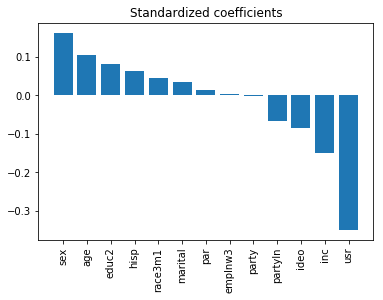

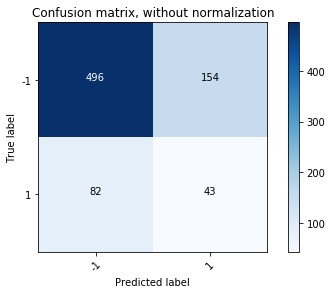

	Accuracy on training data: 0.70
	Accuracy on test data:     0.67
	Metrics for test data
	Precision: 0.21
	Recall: 0.36
	F1 Score: 0.26
	Cohen's Kappa: 0.07
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
5   0.350118    -0.350118  marital
10  0.162523     0.162523     ideo
7   0.150263    -0.150263  emplnw3
4   0.103962     0.103962  race3m1
0   0.085790    -0.085790      sex
3   0.081159     0.081159     hisp
1   0.067640    -0.067640      age
9   0.064224     0.064224  partyln
12  0.046097     0.046097      usr
8   0.035487     0.035487    party
2   0.013594     0.013594    educ2
6   0.003088    -0.003088      par
11  0.002044     0.002044      inc


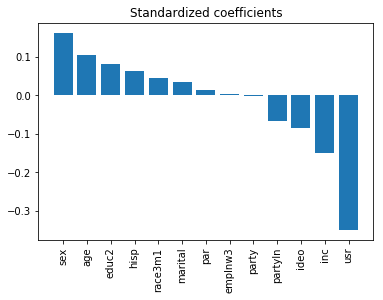

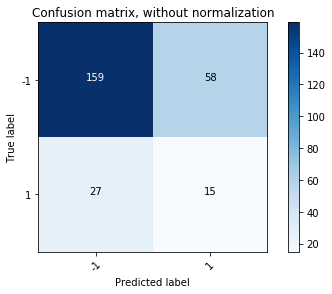


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0: 650, 1: 125}
	Classes in ytest: {0: 217, 1: 42}
	Best Parameters: {'C': 0.001, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.80
	Accuracy on test data:     0.76
	Metrics for train data
	Precision: 0.32
	Recall: 0.21
	F1 Score: 0.25
	Cohen's Kappa: 0.14
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
12  0.024631     0.024631   habits9
9   0.017014     0.017014   habits6
11  0.013224     0.013224   habits8
13  0.012908    -0.012908  habits10
8   0.009818     0.009818   habits5
7   0.009710     0.009710  habits4c
2   0.009600     0.009600  habits1c
15  0.009530     0.009530  habits12
6   0.008304    -0.008304   habits3
5   0.007590    -0.007590   habits2
14  0.006219    -0.006219  habits11
10  0.006115     0.006115   habits7
4   0.005787     0.005787  habits1e
19  0.005644     0.005644    wifi2d
0   0.004395    -0.004395  

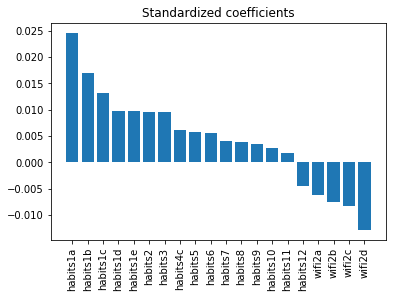

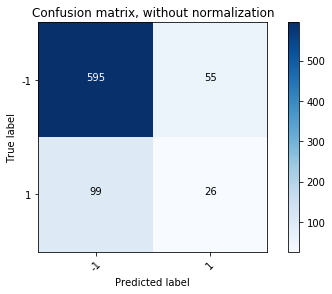

	Accuracy on training data: 0.80
	Accuracy on test data:     0.76
	Metrics for test data
	Precision: 0.19
	Recall: 0.14
	F1 Score: 0.16
	Cohen's Kappa: 0.03
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
12  0.024631     0.024631   habits9
9   0.017014     0.017014   habits6
11  0.013224     0.013224   habits8
13  0.012908    -0.012908  habits10
8   0.009818     0.009818   habits5
7   0.009710     0.009710  habits4c
2   0.009600     0.009600  habits1c
15  0.009530     0.009530  habits12
6   0.008304    -0.008304   habits3
5   0.007590    -0.007590   habits2
14  0.006219    -0.006219  habits11
10  0.006115     0.006115   habits7
4   0.005787     0.005787  habits1e
19  0.005644     0.005644    wifi2d
0   0.004395    -0.004395  habits1a
3   0.004080     0.004080  habits1d
16  0.003882     0.003882    wifi2a
17  0.003421     0.003421    wifi2b
1   0.002711     0.002711  habits1b
18  0.001719     0.001719    wifi2c


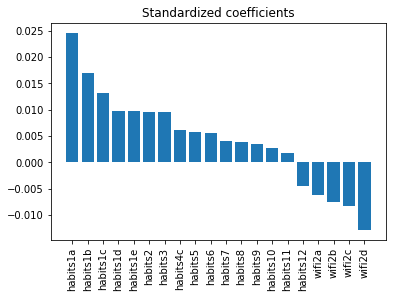

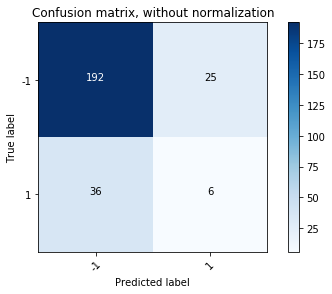


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0: 471, 1: 301}
	Classes in ytest: {0: 157, 1: 101}
	Best Parameters: {'C': 0.1, 'class_weight': {0: 0.4, 1: 0.6}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.62
	Accuracy on test data:     0.56
	Metrics for train data
	Precision: 0.51
	Recall: 0.61
	F1 Score: 0.55
	Cohen's Kappa: 0.22
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
5   0.292909    -0.292909  marital
4   0.210821    -0.210821  race3m1
7   0.199872    -0.199872  emplnw3
10  0.179815     0.179815     ideo
12  0.164364     0.164364      usr
9   0.092769    -0.092769  partyln
2   0.064212    -0.064212    educ2
1   0.060181     0.060181      age
11  0.055302    -0.055302      inc
6   0.027267     0.027267      par
3   0.015698    -0.015698     hisp
0   0.010063     0.010063      sex
8   0.006654    -0.006654    party


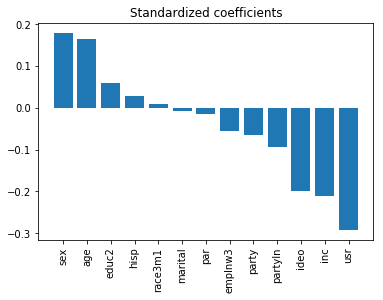

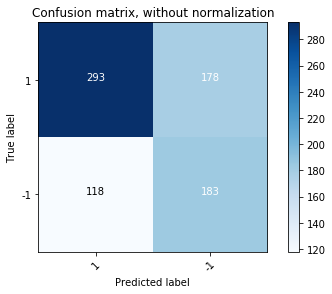

	Accuracy on training data: 0.62
	Accuracy on test data:     0.56
	Metrics for test data
	Precision: 0.45
	Recall: 0.56
	F1 Score: 0.5
	Cohen's Kappa: 0.11
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
5   0.292909    -0.292909  marital
4   0.210821    -0.210821  race3m1
7   0.199872    -0.199872  emplnw3
10  0.179815     0.179815     ideo
12  0.164364     0.164364      usr
9   0.092769    -0.092769  partyln
2   0.064212    -0.064212    educ2
1   0.060181     0.060181      age
11  0.055302    -0.055302      inc
6   0.027267     0.027267      par
3   0.015698    -0.015698     hisp
0   0.010063     0.010063      sex
8   0.006654    -0.006654    party


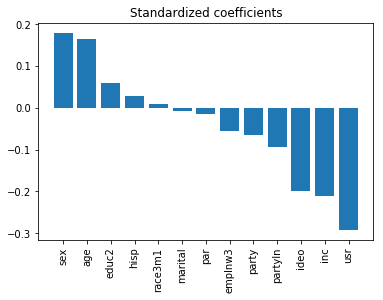

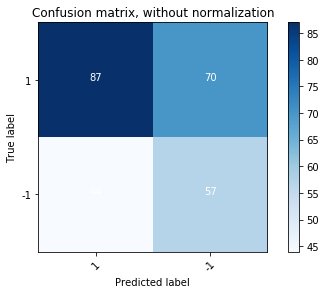


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0: 471, 1: 301}
	Classes in ytest: {0: 157, 1: 101}
	Best Parameters: {'C': 1, 'class_weight': {0: 0.4, 1: 0.6}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.63
	Accuracy on test data:     0.60
	Metrics for train data
	Precision: 0.53
	Recall: 0.61
	F1 Score: 0.56
	Cohen's Kappa: 0.25
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
7   0.247802     0.247802  habits4c
8   0.240296     0.240296   habits5
9   0.236580     0.236580   habits6
15  0.197001     0.197001  habits12
14  0.135126    -0.135126  habits11
6   0.130207     0.130207   habits3
13  0.117144     0.117144  habits10
5   0.107240     0.107240   habits2
4   0.086186    -0.086186  habits1e
19  0.076949     0.076949    wifi2d
1   0.076854    -0.076854  habits1b
2   0.059919    -0.059919  habits1c
10  0.048965     0.048965   habits7
17  0.039626     0.039626    wifi2b
11  0.029016     0.029016   ha

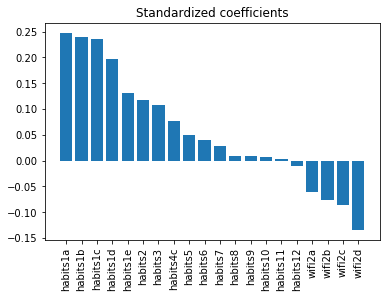

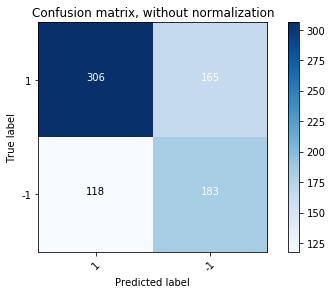

	Accuracy on training data: 0.63
	Accuracy on test data:     0.60
	Metrics for test data
	Precision: 0.5
	Recall: 0.59
	F1 Score: 0.54
	Cohen's Kappa: 0.2
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
7   0.247802     0.247802  habits4c
8   0.240296     0.240296   habits5
9   0.236580     0.236580   habits6
15  0.197001     0.197001  habits12
14  0.135126    -0.135126  habits11
6   0.130207     0.130207   habits3
13  0.117144     0.117144  habits10
5   0.107240     0.107240   habits2
4   0.086186    -0.086186  habits1e
19  0.076949     0.076949    wifi2d
1   0.076854    -0.076854  habits1b
2   0.059919    -0.059919  habits1c
10  0.048965     0.048965   habits7
17  0.039626     0.039626    wifi2b
11  0.029016     0.029016   habits8
0   0.010935    -0.010935  habits1a
16  0.009042     0.009042    wifi2a
3   0.008953     0.008953  habits1d
18  0.006916     0.006916    wifi2c
12  0.002339     0.002339   habits9


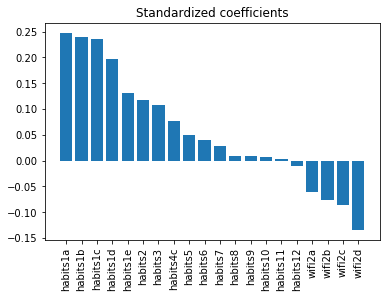

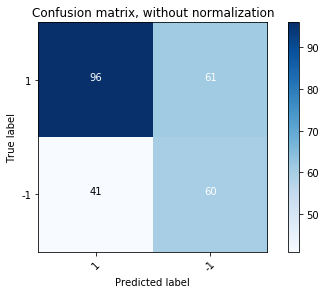


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0: 421, 1: 356}
	Classes in ytest: {0: 140, 1: 119}
	Best Parameters: {'C': 10, 'class_weight': {0: 0.4, 1: 0.6}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.62
	Accuracy on test data:     0.59
	Metrics for train data
	Precision: 0.56
	Recall: 0.78
	F1 Score: 0.65
	Cohen's Kappa: 0.25
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
5   0.417426    -0.417426  marital
12  0.253605     0.253605      usr
7   0.237002    -0.237002  emplnw3
4   0.221193    -0.221193  race3m1
9   0.210969     0.210969  partyln
10  0.176427     0.176427     ideo
3   0.151651    -0.151651     hisp
8   0.113179    -0.113179    party
1   0.096423     0.096423      age
11  0.041965    -0.041965      inc
2   0.015614    -0.015614    educ2
0   0.014207    -0.014207      sex
6   0.011577    -0.011577      par


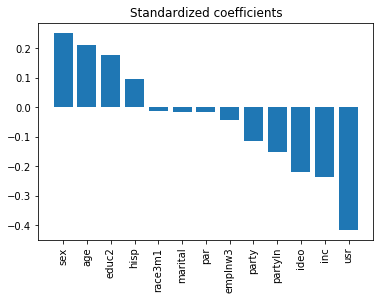

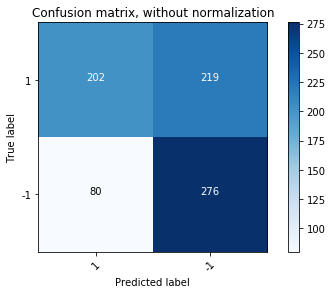

	Accuracy on training data: 0.62
	Accuracy on test data:     0.59
	Metrics for test data
	Precision: 0.54
	Recall: 0.75
	F1 Score: 0.63
	Cohen's Kappa: 0.21
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
5   0.417426    -0.417426  marital
12  0.253605     0.253605      usr
7   0.237002    -0.237002  emplnw3
4   0.221193    -0.221193  race3m1
9   0.210969     0.210969  partyln
10  0.176427     0.176427     ideo
3   0.151651    -0.151651     hisp
8   0.113179    -0.113179    party
1   0.096423     0.096423      age
11  0.041965    -0.041965      inc
2   0.015614    -0.015614    educ2
0   0.014207    -0.014207      sex
6   0.011577    -0.011577      par


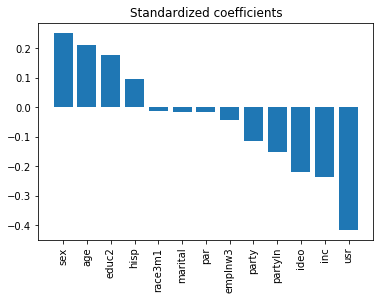

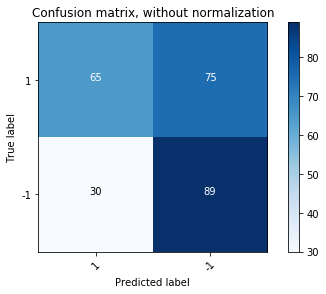


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0: 421, 1: 356}
	Classes in ytest: {0: 140, 1: 119}
	Best Parameters: {'C': 0.01, 'class_weight': {0: 0.4, 1: 0.6}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.59
	Accuracy on test data:     0.58
	Metrics for train data
	Precision: 0.54
	Recall: 0.83
	F1 Score: 0.65
	Cohen's Kappa: 0.21
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
9   0.128953     0.128953   habits6
6   0.104769     0.104769   habits3
12  0.083341     0.083341   habits9
5   0.071759     0.071759   habits2
19  0.061641     0.061641    wifi2d
7   0.058686     0.058686  habits4c
11  0.050574     0.050574   habits8
14  0.046131     0.046131  habits11
8   0.032671     0.032671   habits5
1   0.032541     0.032541  habits1b
2   0.031663     0.031663  habits1c
17  0.022740    -0.022740    wifi2b
16  0.020768     0.020768    wifi2a
18  0.018316     0.018316    wifi2c
0   0.017460     0.017460  

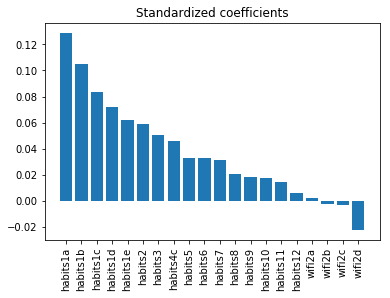

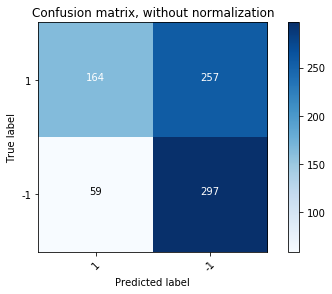

	Accuracy on training data: 0.59
	Accuracy on test data:     0.58
	Metrics for test data
	Precision: 0.53
	Recall: 0.84
	F1 Score: 0.65
	Cohen's Kappa: 0.2
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
9   0.128953     0.128953   habits6
6   0.104769     0.104769   habits3
12  0.083341     0.083341   habits9
5   0.071759     0.071759   habits2
19  0.061641     0.061641    wifi2d
7   0.058686     0.058686  habits4c
11  0.050574     0.050574   habits8
14  0.046131     0.046131  habits11
8   0.032671     0.032671   habits5
1   0.032541     0.032541  habits1b
2   0.031663     0.031663  habits1c
17  0.022740    -0.022740    wifi2b
16  0.020768     0.020768    wifi2a
18  0.018316     0.018316    wifi2c
0   0.017460     0.017460  habits1a
10  0.014090     0.014090   habits7
13  0.005882     0.005882  habits10
3   0.003532    -0.003532  habits1d
4   0.002396    -0.002396  habits1e
15  0.002027     0.002027  habits12


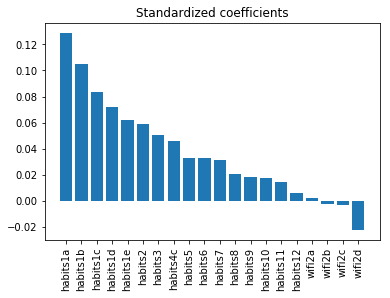

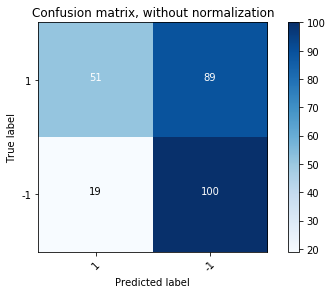


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0: 641, 1: 131}
	Classes in ytest: {0: 214, 1: 44}
	Best Parameters: {'C': 0.1, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.70
	Accuracy on test data:     0.69
	Metrics for train data
	Precision: 0.27
	Recall: 0.44
	F1 Score: 0.33
	Cohen's Kappa: 0.16
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
6   0.251428     0.251428      par
10  0.223552     0.223552     ideo
1   0.188681    -0.188681      age
11  0.155324    -0.155324      inc
7   0.148829    -0.148829  emplnw3
2   0.130274    -0.130274    educ2
4   0.109321    -0.109321  race3m1
0   0.092964     0.092964      sex
12  0.082935     0.082935      usr
5   0.023972     0.023972  marital
8   0.023362     0.023362    party
9   0.013066     0.013066  partyln
3   0.011435    -0.011435     hisp


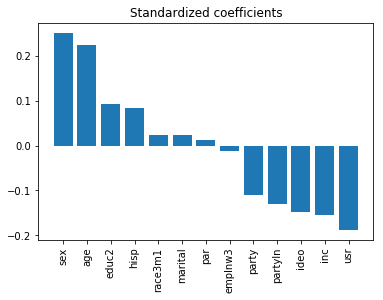

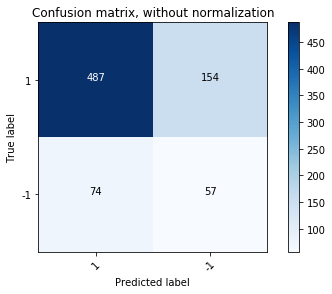

	Accuracy on training data: 0.70
	Accuracy on test data:     0.69
	Metrics for test data
	Precision: 0.25
	Recall: 0.41
	F1 Score: 0.31
	Cohen's Kappa: 0.12
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
6   0.251428     0.251428      par
10  0.223552     0.223552     ideo
1   0.188681    -0.188681      age
11  0.155324    -0.155324      inc
7   0.148829    -0.148829  emplnw3
2   0.130274    -0.130274    educ2
4   0.109321    -0.109321  race3m1
0   0.092964     0.092964      sex
12  0.082935     0.082935      usr
5   0.023972     0.023972  marital
8   0.023362     0.023362    party
9   0.013066     0.013066  partyln
3   0.011435    -0.011435     hisp


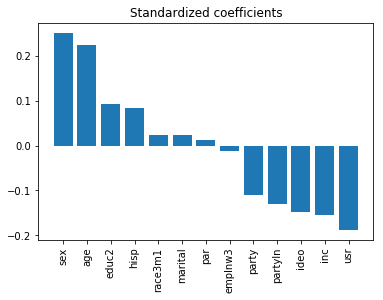

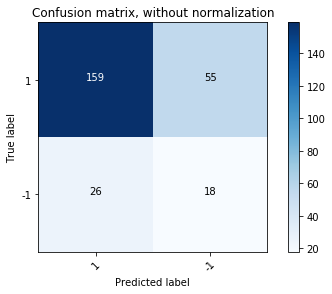


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0: 641, 1: 131}
	Classes in ytest: {0: 214, 1: 44}
	Best Parameters: {'C': 0.01, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.66
	Accuracy on test data:     0.71
	Metrics for train data
	Precision: 0.26
	Recall: 0.54
	F1 Score: 0.35
	Cohen's Kappa: 0.16
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
9   0.104699     0.104699   habits6
12  0.098721     0.098721   habits9
0   0.075460     0.075460  habits1a
7   0.066457     0.066457  habits4c
8   0.064153     0.064153   habits5
4   0.062338     0.062338  habits1e
11  0.059065     0.059065   habits8
15  0.056823     0.056823  habits12
3   0.048232     0.048232  habits1d
6   0.045156     0.045156   habits3
2   0.043094     0.043094  habits1c
18  0.031941     0.031941    wifi2c
10  0.028580     0.028580   habits7
14  0.024203    -0.024203  habits11
13  0.023504    -0.023504  h

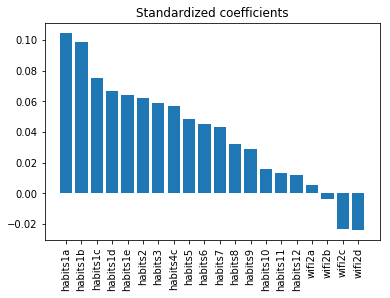

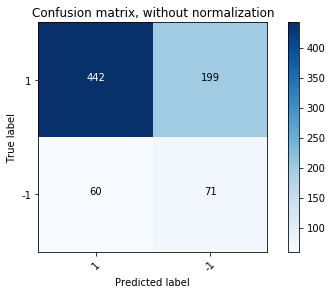

	Accuracy on training data: 0.66
	Accuracy on test data:     0.71
	Metrics for test data
	Precision: 0.31
	Recall: 0.57
	F1 Score: 0.4
	Cohen's Kappa: 0.23
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
9   0.104699     0.104699   habits6
12  0.098721     0.098721   habits9
0   0.075460     0.075460  habits1a
7   0.066457     0.066457  habits4c
8   0.064153     0.064153   habits5
4   0.062338     0.062338  habits1e
11  0.059065     0.059065   habits8
15  0.056823     0.056823  habits12
3   0.048232     0.048232  habits1d
6   0.045156     0.045156   habits3
2   0.043094     0.043094  habits1c
18  0.031941     0.031941    wifi2c
10  0.028580     0.028580   habits7
14  0.024203    -0.024203  habits11
13  0.023504    -0.023504  habits10
5   0.015682     0.015682   habits2
16  0.013170     0.013170    wifi2a
17  0.011932     0.011932    wifi2b
1   0.005377     0.005377  habits1b
19  0.003418    -0.003418    wifi2d


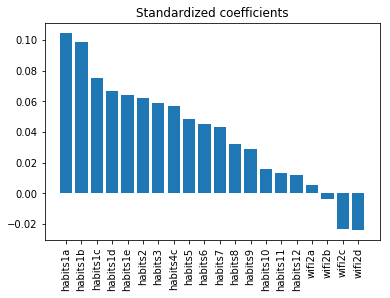

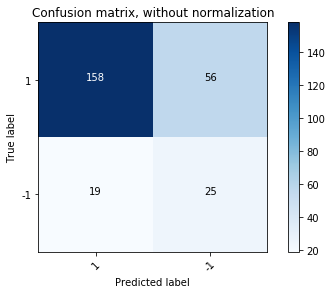


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0: 598, 1: 92}
	Classes in ytest: {0: 200, 1: 31}
	Best Parameters: {'C': 1, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.79
	Accuracy on test data:     0.78
	Metrics for train data
	Precision: 0.27
	Recall: 0.33
	F1 Score: 0.29
	Cohen's Kappa: 0.17
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
1   0.403536    -0.403536      age
5   0.227585     0.227585  marital
0   0.211790     0.211790      sex
8   0.191606    -0.191606    party
11  0.167527    -0.167527      inc
6   0.104381    -0.104381      par
12  0.103610     0.103610      usr
10  0.097748     0.097748     ideo
3   0.096871     0.096871     hisp
4   0.058281     0.058281  race3m1
9   0.042421    -0.042421  partyln
7   0.020793     0.020793  emplnw3
2   0.015530     0.015530    educ2


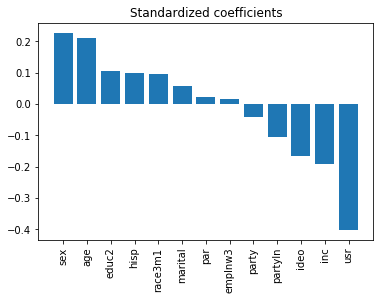

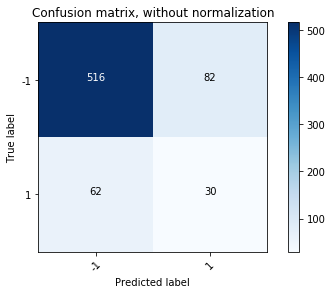

	Accuracy on training data: 0.79
	Accuracy on test data:     0.78
	Metrics for test data
	Precision: 0.19
	Recall: 0.19
	F1 Score: 0.19
	Cohen's Kappa: 0.06
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
1   0.403536    -0.403536      age
5   0.227585     0.227585  marital
0   0.211790     0.211790      sex
8   0.191606    -0.191606    party
11  0.167527    -0.167527      inc
6   0.104381    -0.104381      par
12  0.103610     0.103610      usr
10  0.097748     0.097748     ideo
3   0.096871     0.096871     hisp
4   0.058281     0.058281  race3m1
9   0.042421    -0.042421  partyln
7   0.020793     0.020793  emplnw3
2   0.015530     0.015530    educ2


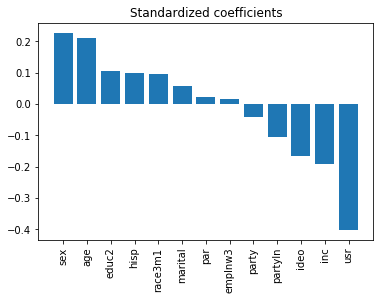

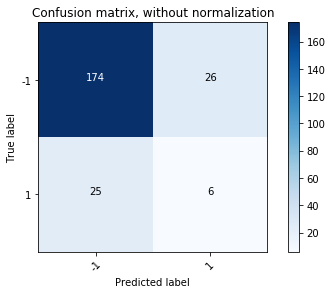


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0: 598, 1: 92}
	Classes in ytest: {0: 200, 1: 31}
	Best Parameters: {'C': 0.1, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.80
	Accuracy on test data:     0.80
	Metrics for train data
	Precision: 0.28
	Recall: 0.33
	F1 Score: 0.3
	Cohen's Kappa: 0.18
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
19  0.278376    -0.278376    wifi2d
3   0.241314     0.241314  habits1d
18  0.235831     0.235831    wifi2c
10  0.226937     0.226937   habits7
15  0.173371     0.173371  habits12
13  0.093285    -0.093285  habits10
4   0.089729     0.089729  habits1e
12  0.084676     0.084676   habits9
1   0.075549     0.075549  habits1b
8   0.064005     0.064005   habits5
0   0.063344     0.063344  habits1a
6   0.062201    -0.062201   habits3
9   0.055275     0.055275   habits6
17  0.046756     0.046756    wifi2b
11  0.020762     0.020762   hab

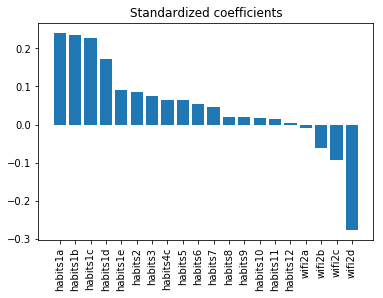

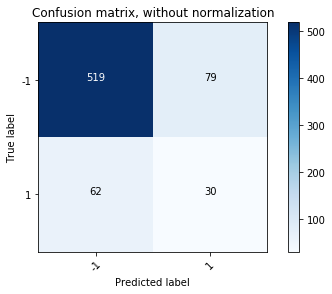

	Accuracy on training data: 0.80
	Accuracy on test data:     0.80
	Metrics for test data
	Precision: 0.24
	Recall: 0.23
	F1 Score: 0.23
	Cohen's Kappa: 0.12
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
19  0.278376    -0.278376    wifi2d
3   0.241314     0.241314  habits1d
18  0.235831     0.235831    wifi2c
10  0.226937     0.226937   habits7
15  0.173371     0.173371  habits12
13  0.093285    -0.093285  habits10
4   0.089729     0.089729  habits1e
12  0.084676     0.084676   habits9
1   0.075549     0.075549  habits1b
8   0.064005     0.064005   habits5
0   0.063344     0.063344  habits1a
6   0.062201    -0.062201   habits3
9   0.055275     0.055275   habits6
17  0.046756     0.046756    wifi2b
11  0.020762     0.020762   habits8
5   0.020717     0.020717   habits2
7   0.016526     0.016526  habits4c
14  0.015074     0.015074  habits11
16  0.009301    -0.009301    wifi2a
2   0.004050     0.004050  habits1c


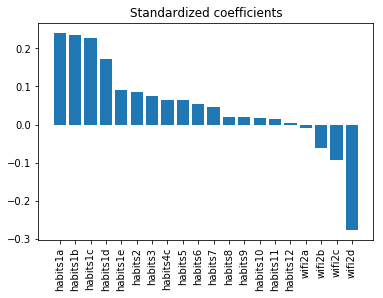

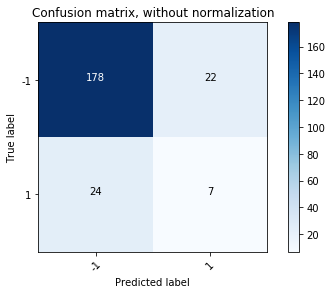


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0: 653, 1: 115}
	Classes in ytest: {0: 218, 1: 38}
	Best Parameters: {'C': 0.01, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.82
	Accuracy on test data:     0.81
	Metrics for train data
	Precision: 0.27
	Recall: 0.12
	F1 Score: 0.17
	Cohen's Kappa: 0.08
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
2   0.374749    -0.374749    educ2
5   0.121871    -0.121871  marital
11  0.090019     0.090019      inc
4   0.067268     0.067268  race3m1
6   0.036596     0.036596      par
8   0.030297    -0.030297    party
7   0.029064    -0.029064  emplnw3
3   0.024167     0.024167     hisp
10  0.020065    -0.020065     ideo
1   0.018934     0.018934      age
9   0.004487    -0.004487  partyln
0   0.001862    -0.001862      sex
12  0.001350     0.001350      usr


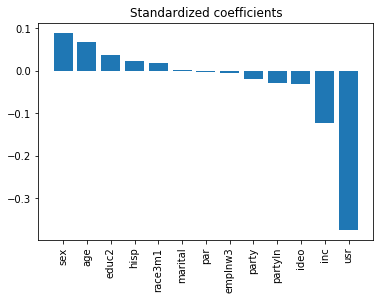

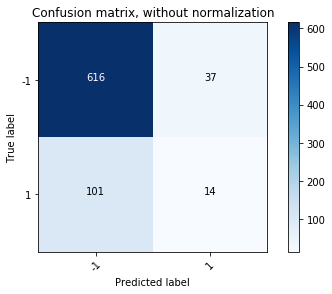

	Accuracy on training data: 0.82
	Accuracy on test data:     0.81
	Metrics for test data
	Precision: 0.08
	Recall: 0.03
	F1 Score: 0.04
	Cohen's Kappa: -0.04
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
2   0.374749    -0.374749    educ2
5   0.121871    -0.121871  marital
11  0.090019     0.090019      inc
4   0.067268     0.067268  race3m1
6   0.036596     0.036596      par
8   0.030297    -0.030297    party
7   0.029064    -0.029064  emplnw3
3   0.024167     0.024167     hisp
10  0.020065    -0.020065     ideo
1   0.018934     0.018934      age
9   0.004487    -0.004487  partyln
0   0.001862    -0.001862      sex
12  0.001350     0.001350      usr


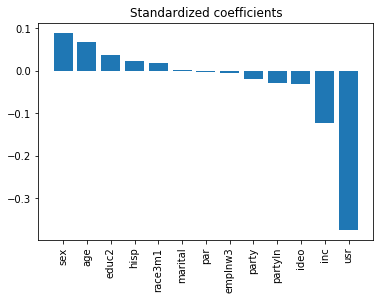

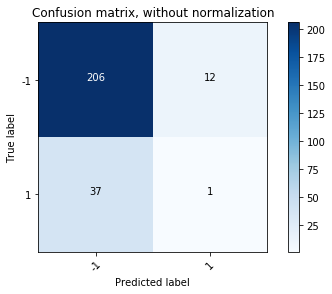


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0: 653, 1: 115}
	Classes in ytest: {0: 218, 1: 38}
	Best Parameters: {'C': 1, 'class_weight': {0: 0.1, 1: 0.9}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.30
	Accuracy on test data:     0.31
	Metrics for train data
	Precision: 0.16
	Recall: 0.9
	F1 Score: 0.28
	Cohen's Kappa: 0.03
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
16  0.266041     0.266041    wifi2a
13  0.260841     0.260841  habits10
12  0.252711     0.252711   habits9
11  0.231092    -0.231092   habits8
5   0.224942     0.224942   habits2
18  0.206455    -0.206455    wifi2c
1   0.192560    -0.192560  habits1b
14  0.172786    -0.172786  habits11
8   0.154044    -0.154044   habits5
2   0.147306    -0.147306  habits1c
15  0.138742     0.138742  habits12
7   0.127344     0.127344  habits4c
17  0.093150    -0.093150    wifi2b
3   0.079837    -0.079837  habits1d
4   0.068162     0.068162  habit

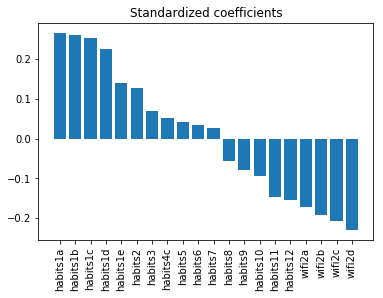

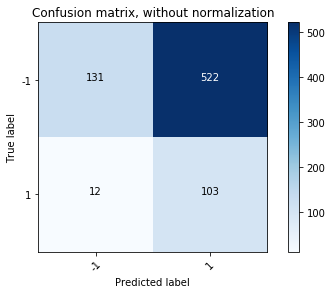

	Accuracy on training data: 0.30
	Accuracy on test data:     0.31
	Metrics for test data
	Precision: 0.16
	Recall: 0.87
	F1 Score: 0.27
	Cohen's Kappa: 0.03
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
16  0.266041     0.266041    wifi2a
13  0.260841     0.260841  habits10
12  0.252711     0.252711   habits9
11  0.231092    -0.231092   habits8
5   0.224942     0.224942   habits2
18  0.206455    -0.206455    wifi2c
1   0.192560    -0.192560  habits1b
14  0.172786    -0.172786  habits11
8   0.154044    -0.154044   habits5
2   0.147306    -0.147306  habits1c
15  0.138742     0.138742  habits12
7   0.127344     0.127344  habits4c
17  0.093150    -0.093150    wifi2b
3   0.079837    -0.079837  habits1d
4   0.068162     0.068162  habits1e
0   0.055830    -0.055830  habits1a
9   0.051768     0.051768   habits6
19  0.042352     0.042352    wifi2d
6   0.034765     0.034765   habits3
10  0.026781     0.026781   habits7


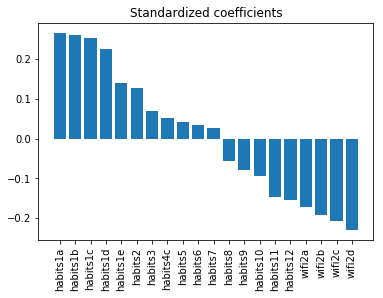

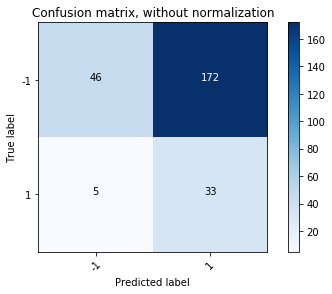


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {0: 727, 1: 43}
	Classes in ytest: {0: 243, 1: 14}
	Best Parameters: {'C': 1, 'class_weight': {0: 0.1, 1: 0.9}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.87
	Accuracy on test data:     0.83
	Metrics for train data
	Precision: 0.13
	Recall: 0.23
	F1 Score: 0.17
	Cohen's Kappa: 0.1
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
3   0.361268     0.361268     hisp
9   0.281571     0.281571  partyln
1   0.260168     0.260168      age
8   0.230604    -0.230604    party
0   0.219252     0.219252      sex
5   0.197588     0.197588  marital
11  0.149701    -0.149701      inc
4   0.143127    -0.143127  race3m1
12  0.137932    -0.137932      usr
10  0.104700    -0.104700     ideo
2   0.098494     0.098494    educ2
7   0.060784    -0.060784  emplnw3
6   0.000552    -0.000552      par


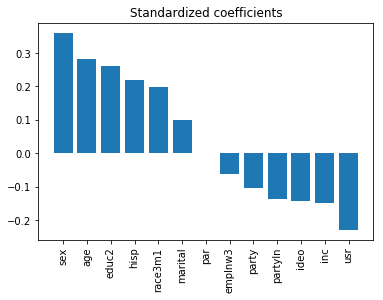

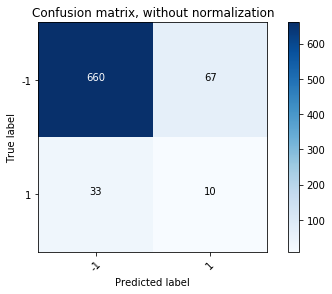

	Accuracy on training data: 0.87
	Accuracy on test data:     0.83
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.08
	
Standardized coefficients

    Coeff_AV  Coefficient  Feature
3   0.361268     0.361268     hisp
9   0.281571     0.281571  partyln
1   0.260168     0.260168      age
8   0.230604    -0.230604    party
0   0.219252     0.219252      sex
5   0.197588     0.197588  marital
11  0.149701    -0.149701      inc
4   0.143127    -0.143127  race3m1
12  0.137932    -0.137932      usr
10  0.104700    -0.104700     ideo
2   0.098494     0.098494    educ2
7   0.060784    -0.060784  emplnw3
6   0.000552    -0.000552      par


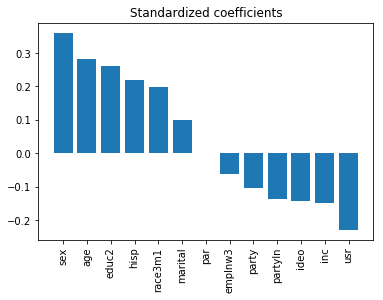

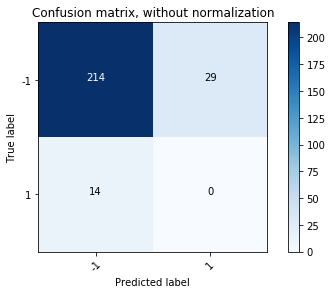


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {0: 727, 1: 43}
	Classes in ytest: {0: 243, 1: 14}
	Best Parameters: {'C': 1, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.93
	Metrics for train data
	Precision: 0.27
	Recall: 0.07
	F1 Score: 0.11
	Cohen's Kappa: 0.09
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
6   0.467013    -0.467013   habits3
19  0.387724    -0.387724    wifi2d
10  0.353176    -0.353176   habits7
2   0.283708     0.283708  habits1c
5   0.272490    -0.272490   habits2
4   0.269089     0.269089  habits1e
7   0.190573     0.190573  habits4c
1   0.186438     0.186438  habits1b
11  0.175256    -0.175256   habits8
17  0.157943     0.157943    wifi2b
9   0.136668     0.136668   habits6
3   0.123020     0.123020  habits1d
8   0.122808    -0.122808   habits5
15  0.111948     0.111948  habits12
14  0.103989    -0.103989  habit

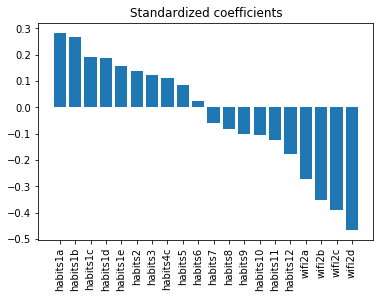

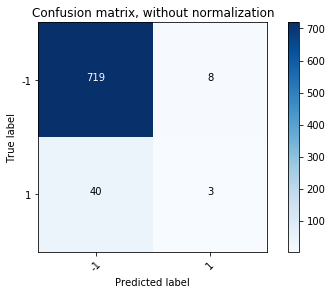

	Accuracy on training data: 0.94
	Accuracy on test data:     0.93
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.03
	
Standardized coefficients

    Coeff_AV  Coefficient   Feature
6   0.467013    -0.467013   habits3
19  0.387724    -0.387724    wifi2d
10  0.353176    -0.353176   habits7
2   0.283708     0.283708  habits1c
5   0.272490    -0.272490   habits2
4   0.269089     0.269089  habits1e
7   0.190573     0.190573  habits4c
1   0.186438     0.186438  habits1b
11  0.175256    -0.175256   habits8
17  0.157943     0.157943    wifi2b
9   0.136668     0.136668   habits6
3   0.123020     0.123020  habits1d
8   0.122808    -0.122808   habits5
15  0.111948     0.111948  habits12
14  0.103989    -0.103989  habits11
12  0.102351    -0.102351   habits9
18  0.083740    -0.083740    wifi2c
13  0.083459     0.083459  habits10
16  0.060856    -0.060856    wifi2a
0   0.025099     0.025099  habits1a


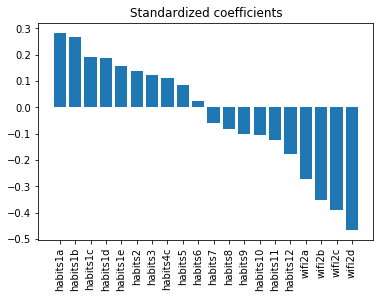

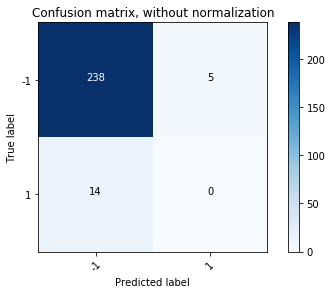

In [27]:
from sklearn.linear_model import LogisticRegression

clf_str = 'logreg'
mod_results = []

# create dictionary of parameters
dict_params = {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'class_weight': [{0:.1, 1:.9},
                                {0:.2, 1:.8},
                                {0:.3, 1:.7},
                                {0:.4, 1:.6},
                                {0:.5, 1:.5},
                                {0:.6, 1:.4},
                                {0:.7, 1:.3},
                                {0:.8, 1:.2},
                                {0:.9, 1:.1}],
              'fit_intercept': [False]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        # remove ID from dem_cols
        x_cols = dem_cols[:]
        x_cols.remove('ID')
        
        """ ======= PERFORM LOGISTIC REGRESSION W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """

        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        clf, Xtrain, ytrain, Xtest, ytest, mod_results = do_classify(clf=LogisticRegression(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results=mod_results,
                                                                    clf_str=clf_str)

        # remove ID from hab_cols
        x_cols = hab_cols[:]
        x_cols.remove('ID')        
        
        """ ======= PERFORM LOGISTIC REGRESSION W/ SECURITY HABIT VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest, mod_results = do_classify(clf=LogisticRegression(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results = mod_results,
                                                                     clf_str=clf_str)
        
        curr_mod_results = pd.DataFrame(mod_results) 
        
# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()
df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>KNN</h1>
</div>


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 650, 1: 125}
	Classes in ytest: {-1: 217, 1: 42}
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.83
	Metrics for train data
	Precision: 0.68
	Recall: 0.15
	F1 Score: 0.25
	Cohen's Kappa: 0.2


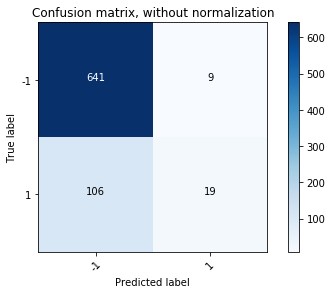

	Accuracy on training data: 0.85
	Accuracy on test data:     0.83
	Metrics for test data
	Precision: 0.4
	Recall: 0.05
	F1 Score: 0.09
	Cohen's Kappa: 0.05


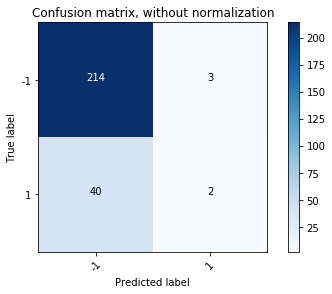


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 650, 1: 125}
	Classes in ytest: {-1: 217, 1: 42}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.76
	Metrics for train data
	Precision: 0.99
	Recall: 0.9
	F1 Score: 0.95
	Cohen's Kappa: 0.94


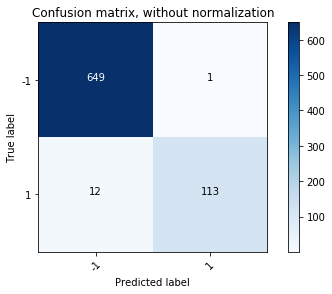

	Accuracy on training data: 0.98
	Accuracy on test data:     0.76
	Metrics for test data
	Precision: 0.22
	Recall: 0.19
	F1 Score: 0.21
	Cohen's Kappa: 0.07


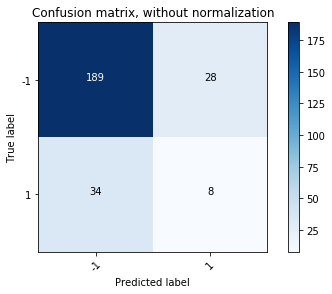


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 471, 1: 301}
	Classes in ytest: {-1: 157, 1: 101}
	Best Parameters: {'n_neighbors': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.70
	Accuracy on test data:     0.61
	Metrics for train data
	Precision: 0.65
	Recall: 0.5
	F1 Score: 0.56
	Cohen's Kappa: 0.34


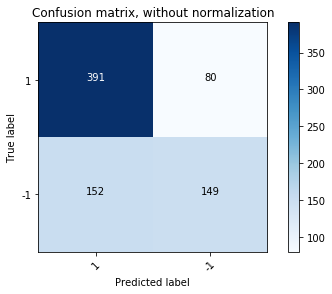

	Accuracy on training data: 0.70
	Accuracy on test data:     0.61
	Metrics for test data
	Precision: 0.51
	Recall: 0.35
	F1 Score: 0.41
	Cohen's Kappa: 0.14


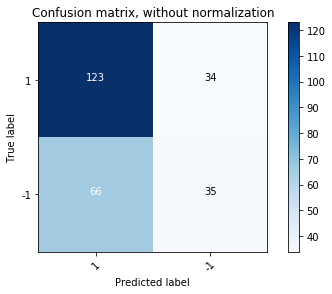


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 471, 1: 301}
	Classes in ytest: {-1: 157, 1: 101}
	Best Parameters: {'n_neighbors': 20}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.64
	Accuracy on test data:     0.57
	Metrics for train data
	Precision: 0.6
	Recall: 0.2
	F1 Score: 0.3
	Cohen's Kappa: 0.13


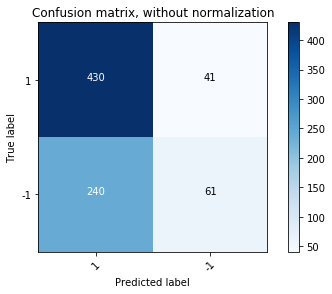

	Accuracy on training data: 0.64
	Accuracy on test data:     0.57
	Metrics for test data
	Precision: 0.33
	Recall: 0.11
	F1 Score: 0.16
	Cohen's Kappa: -0.04


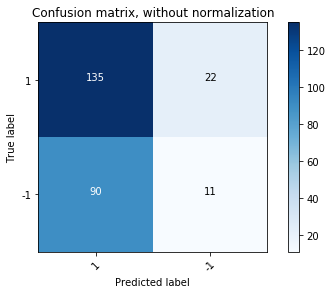


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 421, 1: 356}
	Classes in ytest: {-1: 140, 1: 119}
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.73
	Accuracy on test data:     0.59
	Metrics for train data
	Precision: 0.71
	Recall: 0.71
	F1 Score: 0.71
	Cohen's Kappa: 0.46


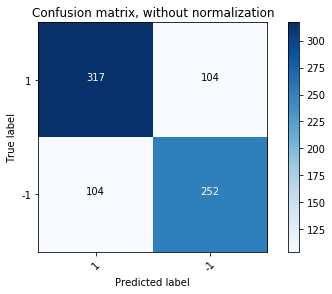

	Accuracy on training data: 0.73
	Accuracy on test data:     0.59
	Metrics for test data
	Precision: 0.55
	Recall: 0.6
	F1 Score: 0.57
	Cohen's Kappa: 0.17


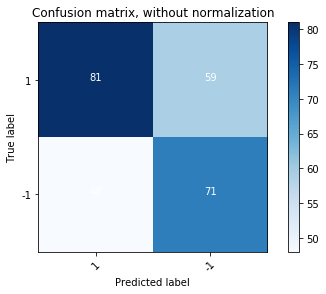


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 421, 1: 356}
	Classes in ytest: {-1: 140, 1: 119}
	Best Parameters: {'n_neighbors': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.65
	Accuracy on test data:     0.55
	Metrics for train data
	Precision: 0.64
	Recall: 0.53
	F1 Score: 0.58
	Cohen's Kappa: 0.29


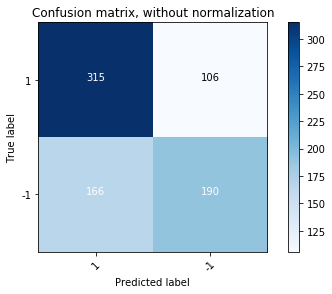

	Accuracy on training data: 0.65
	Accuracy on test data:     0.55
	Metrics for test data
	Precision: 0.51
	Recall: 0.38
	F1 Score: 0.43
	Cohen's Kappa: 0.07


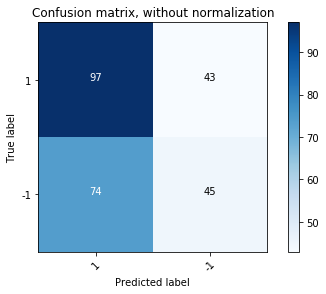


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 641, 1: 131}
	Classes in ytest: {-1: 214, 1: 44}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.71
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


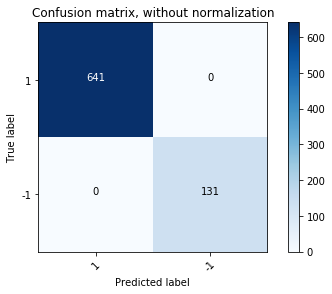

	Accuracy on training data: 1.00
	Accuracy on test data:     0.71
	Metrics for test data
	Precision: 0.19
	Recall: 0.2
	F1 Score: 0.2
	Cohen's Kappa: 0.02


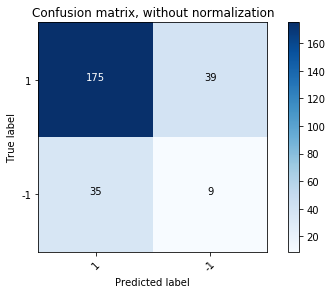


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 641, 1: 131}
	Classes in ytest: {-1: 214, 1: 44}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.72
	Metrics for train data
	Precision: 0.98
	Recall: 0.98
	F1 Score: 0.98
	Cohen's Kappa: 0.98


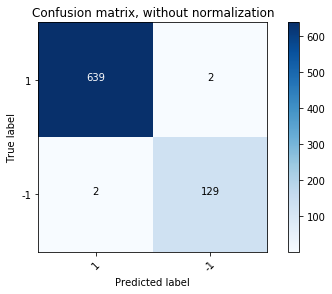

	Accuracy on training data: 0.99
	Accuracy on test data:     0.72
	Metrics for test data
	Precision: 0.19
	Recall: 0.2
	F1 Score: 0.2
	Cohen's Kappa: 0.03


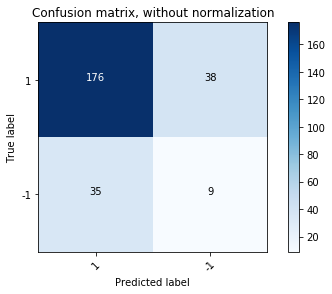


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 598, 1: 92}
	Classes in ytest: {-1: 200, 1: 31}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.78
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


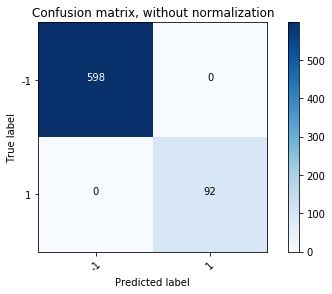

	Accuracy on training data: 1.00
	Accuracy on test data:     0.78
	Metrics for test data
	Precision: 0.08
	Recall: 0.06
	F1 Score: 0.07
	Cohen's Kappa: -0.05


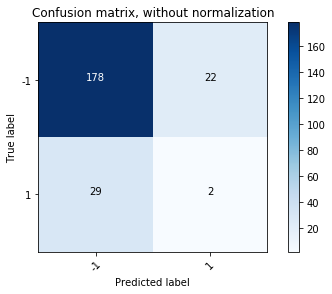


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 598, 1: 92}
	Classes in ytest: {-1: 200, 1: 31}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.81
	Metrics for train data
	Precision: 1.0
	Recall: 0.96
	F1 Score: 0.98
	Cohen's Kappa: 0.97


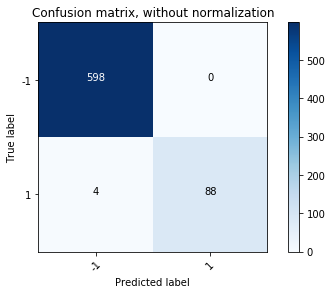

	Accuracy on training data: 0.99
	Accuracy on test data:     0.81
	Metrics for test data
	Precision: 0.26
	Recall: 0.23
	F1 Score: 0.24
	Cohen's Kappa: 0.13


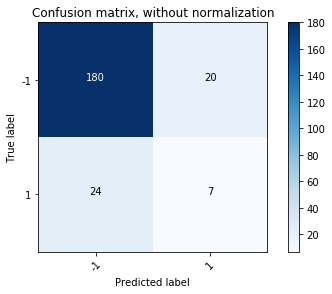


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 653, 1: 115}
	Classes in ytest: {-1: 218, 1: 38}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.75
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


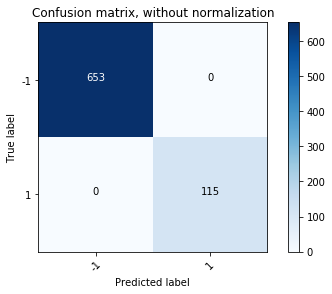

	Accuracy on training data: 1.00
	Accuracy on test data:     0.75
	Metrics for test data
	Precision: 0.14
	Recall: 0.13
	F1 Score: 0.14
	Cohen's Kappa: -0.01


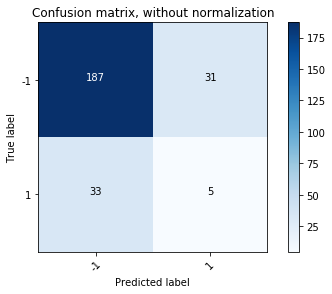


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 653, 1: 115}
	Classes in ytest: {-1: 218, 1: 38}
	Best Parameters: {'n_neighbors': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.87
	Accuracy on test data:     0.86
	Metrics for train data
	Precision: 0.88
	Recall: 0.12
	F1 Score: 0.21
	Cohen's Kappa: 0.18


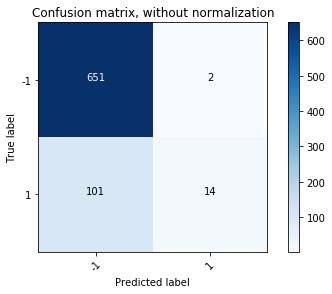

	Accuracy on training data: 0.87
	Accuracy on test data:     0.86
	Metrics for test data
	Precision: 1.0
	Recall: 0.03
	F1 Score: 0.05
	Cohen's Kappa: 0.04


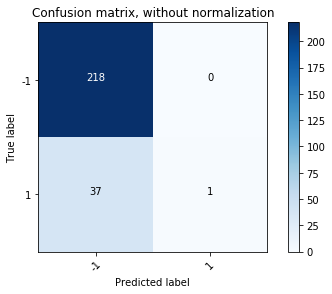


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 727, 1: 43}
	Classes in ytest: {-1: 243, 1: 14}
	Best Parameters: {'n_neighbors': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.91
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


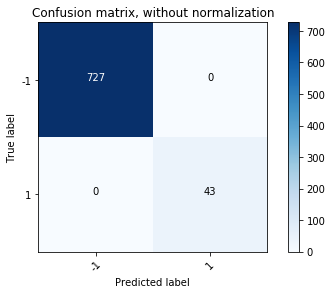

	Accuracy on training data: 1.00
	Accuracy on test data:     0.91
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.04


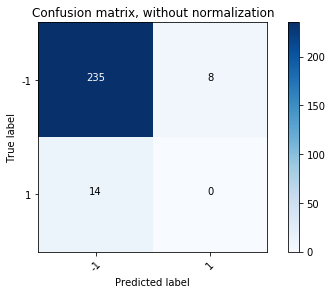


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 727, 1: 43}
	Classes in ytest: {-1: 243, 1: 14}
	Best Parameters: {'n_neighbors': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	Metrics for train data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


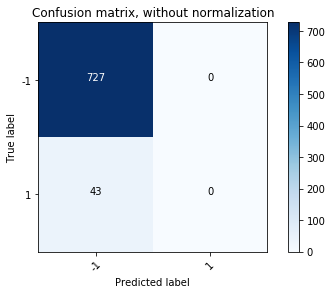

	Accuracy on training data: 0.94
	Accuracy on test data:     0.95
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


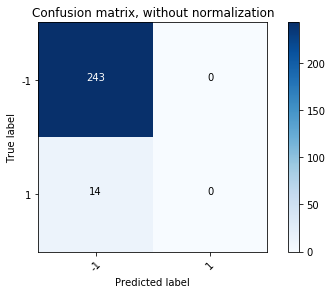

In [28]:
from sklearn.neighbors import KNeighborsClassifier

clf_str = 'knn'
mod_results = []

# create dictionary of parameters
dict_params = {'n_neighbors': [1, 5, 10, 15, 20]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        # remove ID from dem_cols
        x_cols = dem_cols[:]
        x_cols.remove('ID')
        
        """ ======= PERFORM KNN W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """
        
        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        clf, Xtrain, ytrain, Xtest, ytest, mod_results  = do_classify(clf=KNeighborsClassifier(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results=mod_results,
                                                         clf_str=clf_str)
        
        # remove ID from hab_cols
        x_cols = hab_cols[:]
        x_cols.remove('ID')
        
        """ ======= PERFORM KNN W/ SECURITY HABIT VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest, mod_results = do_classify(clf=KNeighborsClassifier(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results=mod_results,
                                                         clf_str=clf_str)
        curr_mod_results = pd.DataFrame(mod_results) 

# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()

df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>RANDOM FORESTS</h1>
</div>

### Perform Random Forest


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 650, 1: 125}
	Classes in ytest: {-1: 217, 1: 42}
	Best Parameters: {'min_samples_split': 4, 'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.93
	Accuracy on test data:     0.81
	Metrics for train data
	Precision: 0.91
	Recall: 0.62
	F1 Score: 0.74
	Cohen's Kappa: 0.7


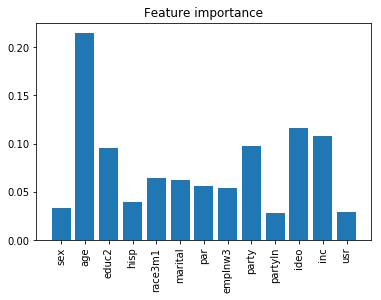

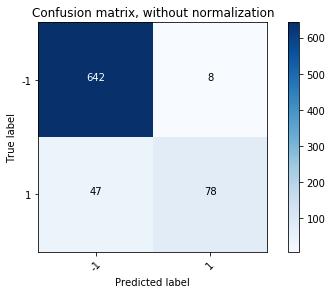

	Accuracy on training data: 0.93
	Accuracy on test data:     0.81
	Metrics for test data
	Precision: 0.12
	Recall: 0.02
	F1 Score: 0.04
	Cohen's Kappa: -0.01


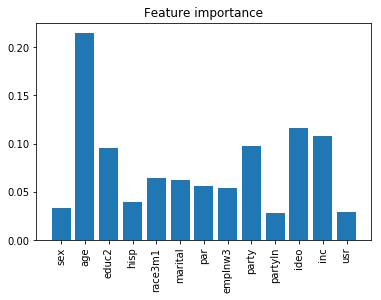

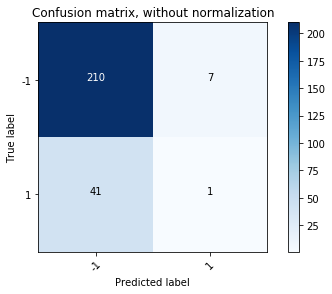


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 650, 1: 125}
	Classes in ytest: {-1: 217, 1: 42}
	Best Parameters: {'min_samples_split': 7, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.81
	Metrics for train data
	Precision: 0.57
	Recall: 0.18
	F1 Score: 0.28
	Cohen's Kappa: 0.22


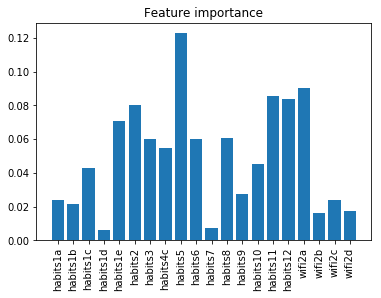

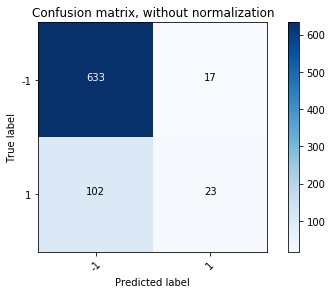

	Accuracy on training data: 0.85
	Accuracy on test data:     0.81
	Metrics for test data
	Precision: 0.12
	Recall: 0.02
	F1 Score: 0.04
	Cohen's Kappa: -0.01


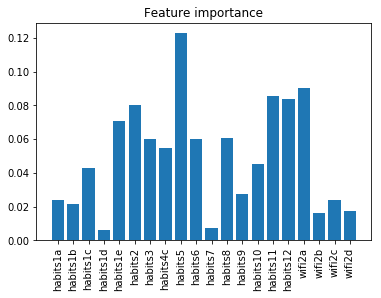

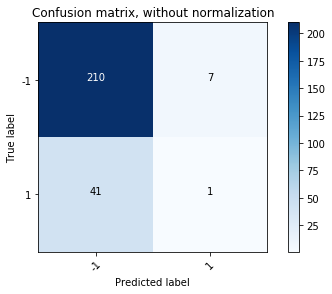


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 471, 1: 301}
	Classes in ytest: {-1: 157, 1: 101}
	Best Parameters: {'min_samples_split': 20, 'n_estimators': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.80
	Accuracy on test data:     0.62
	Metrics for train data
	Precision: 0.8
	Recall: 0.63
	F1 Score: 0.71
	Cohen's Kappa: 0.55


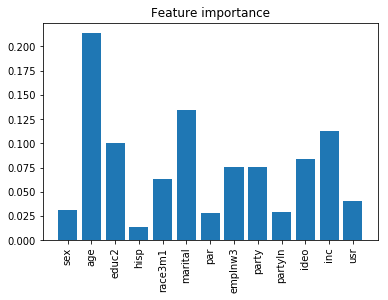

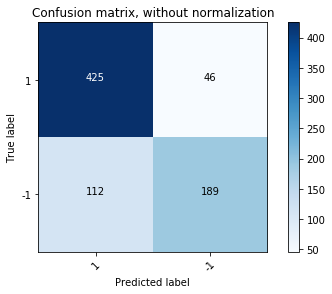

	Accuracy on training data: 0.80
	Accuracy on test data:     0.62
	Metrics for test data
	Precision: 0.53
	Recall: 0.4
	F1 Score: 0.45
	Cohen's Kappa: 0.17


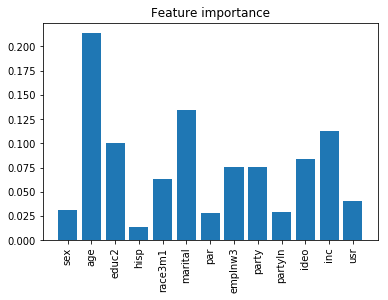

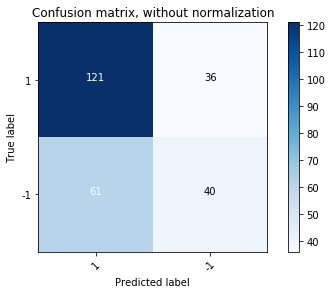


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 471, 1: 301}
	Classes in ytest: {-1: 157, 1: 101}
	Best Parameters: {'min_samples_split': 6, 'n_estimators': 15}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.89
	Accuracy on test data:     0.57
	Metrics for train data
	Precision: 0.95
	Recall: 0.75
	F1 Score: 0.84
	Cohen's Kappa: 0.76


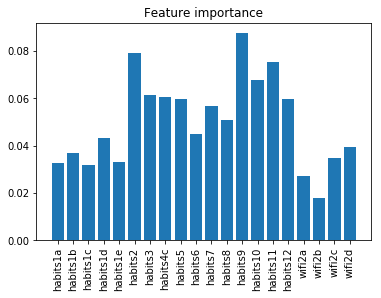

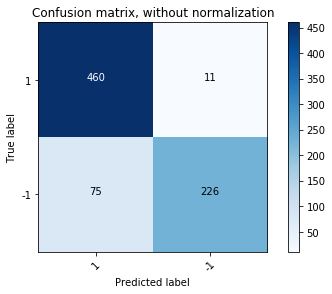

	Accuracy on training data: 0.89
	Accuracy on test data:     0.57
	Metrics for test data
	Precision: 0.42
	Recall: 0.27
	F1 Score: 0.33
	Cohen's Kappa: 0.03


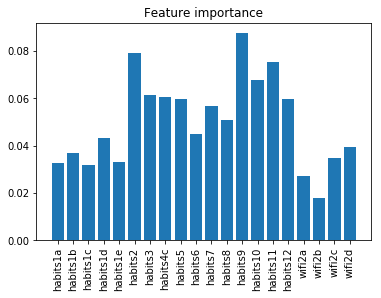

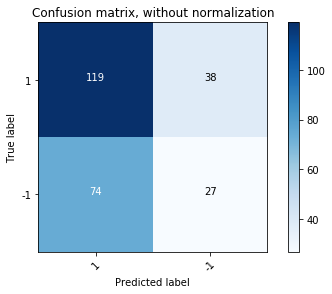


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 421, 1: 356}
	Classes in ytest: {-1: 140, 1: 119}
	Best Parameters: {'min_samples_split': 9, 'n_estimators': 10}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.60
	Metrics for train data
	Precision: 0.88
	Recall: 0.79
	F1 Score: 0.83
	Cohen's Kappa: 0.7


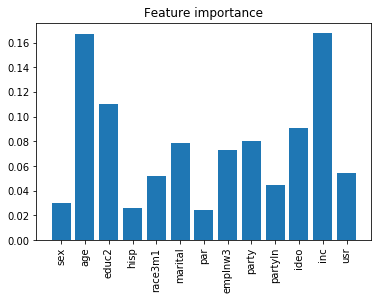

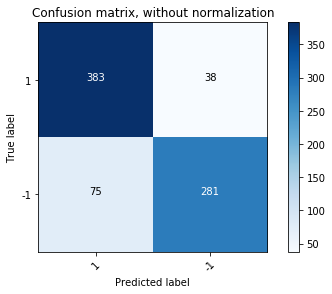

	Accuracy on training data: 0.85
	Accuracy on test data:     0.60
	Metrics for test data
	Precision: 0.59
	Recall: 0.45
	F1 Score: 0.51
	Cohen's Kappa: 0.18


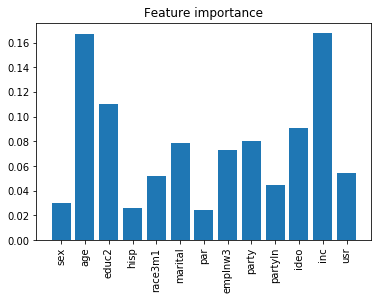

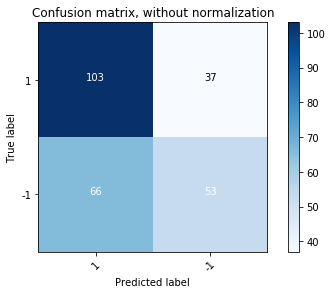


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 421, 1: 356}
	Classes in ytest: {-1: 140, 1: 119}
	Best Parameters: {'min_samples_split': 20, 'n_estimators': 25}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.79
	Accuracy on test data:     0.56
	Metrics for train data
	Precision: 0.79
	Recall: 0.75
	F1 Score: 0.77
	Cohen's Kappa: 0.58


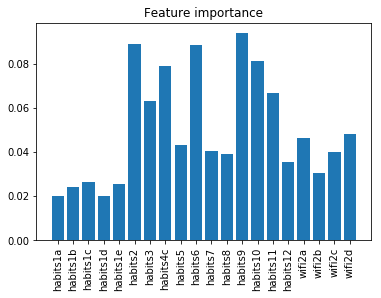

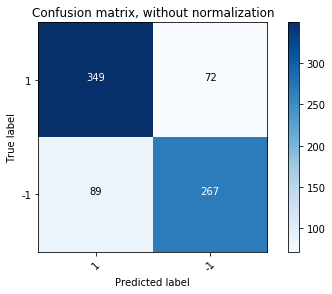

	Accuracy on training data: 0.79
	Accuracy on test data:     0.56
	Metrics for test data
	Precision: 0.53
	Recall: 0.51
	F1 Score: 0.52
	Cohen's Kappa: 0.12


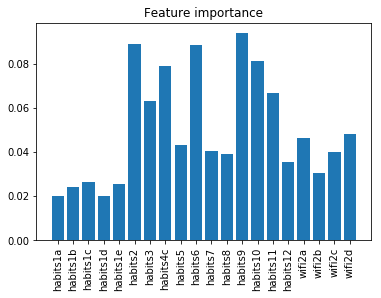

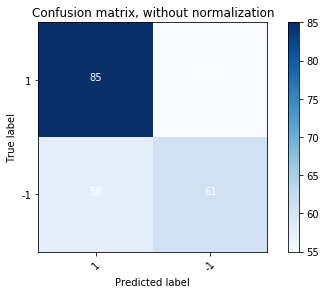


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 641, 1: 131}
	Classes in ytest: {-1: 214, 1: 44}
	Best Parameters: {'min_samples_split': 7, 'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.89
	Accuracy on test data:     0.80
	Metrics for train data
	Precision: 0.84
	Recall: 0.44
	F1 Score: 0.57
	Cohen's Kappa: 0.52


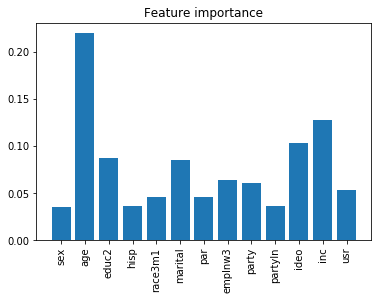

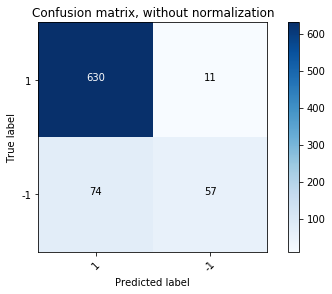

	Accuracy on training data: 0.89
	Accuracy on test data:     0.80
	Metrics for test data
	Precision: 0.17
	Recall: 0.05
	F1 Score: 0.07
	Cohen's Kappa: -0.0


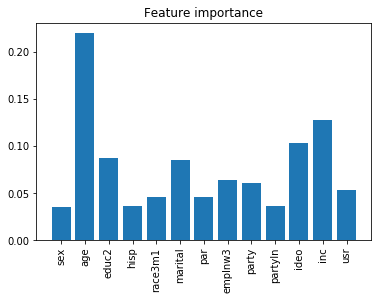

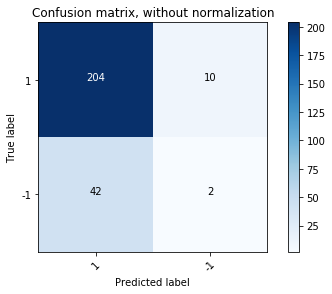


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 641, 1: 131}
	Classes in ytest: {-1: 214, 1: 44}
	Best Parameters: {'min_samples_split': 4, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.86
	Accuracy on test data:     0.76
	Metrics for train data
	Precision: 0.6
	Recall: 0.49
	F1 Score: 0.54
	Cohen's Kappa: 0.45


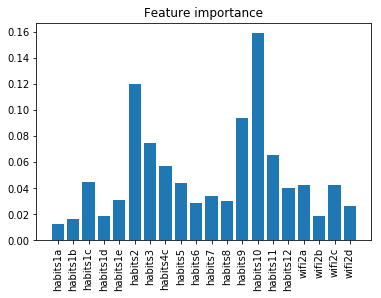

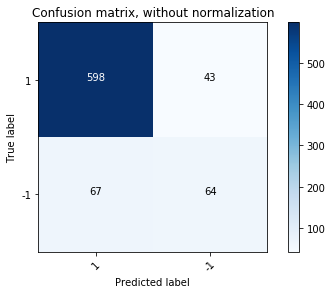

	Accuracy on training data: 0.86
	Accuracy on test data:     0.76
	Metrics for test data
	Precision: 0.26
	Recall: 0.23
	F1 Score: 0.24
	Cohen's Kappa: 0.1


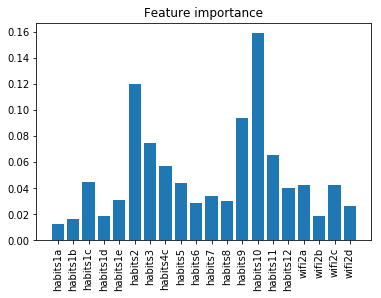

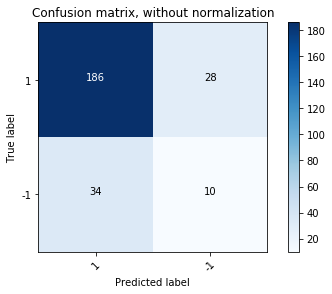


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 598, 1: 92}
	Classes in ytest: {-1: 200, 1: 31}
	Best Parameters: {'min_samples_split': 10, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.86
	Accuracy on test data:     0.84
	Metrics for train data
	Precision: 0.47
	Recall: 0.22
	F1 Score: 0.3
	Cohen's Kappa: 0.23


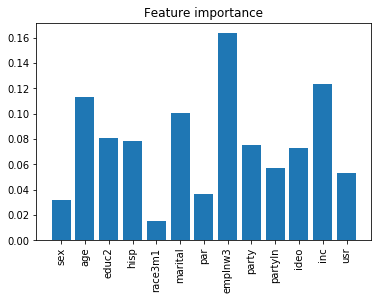

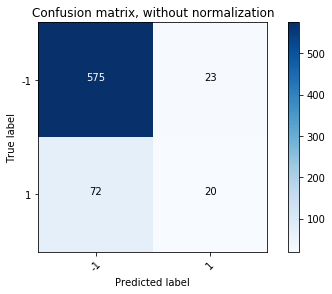

	Accuracy on training data: 0.86
	Accuracy on test data:     0.84
	Metrics for test data
	Precision: 0.25
	Recall: 0.1
	F1 Score: 0.14
	Cohen's Kappa: 0.07


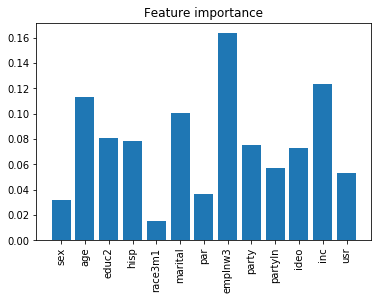

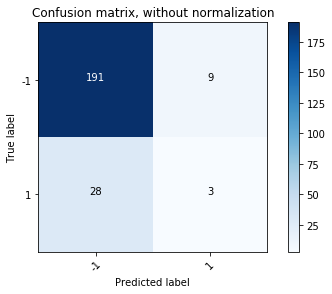


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 598, 1: 92}
	Classes in ytest: {-1: 200, 1: 31}
	Best Parameters: {'min_samples_split': 3, 'n_estimators': 5}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.93
	Accuracy on test data:     0.84
	Metrics for train data
	Precision: 0.92
	Recall: 0.5
	F1 Score: 0.65
	Cohen's Kappa: 0.61


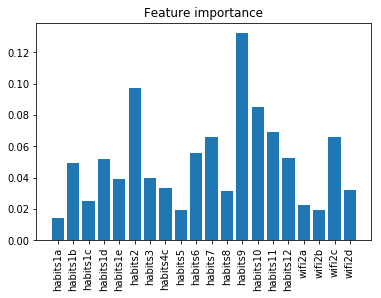

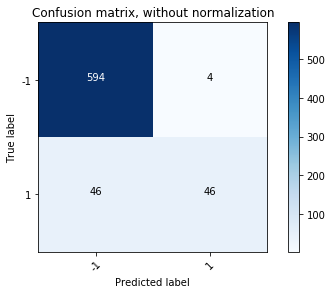

	Accuracy on training data: 0.93
	Accuracy on test data:     0.84
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.05


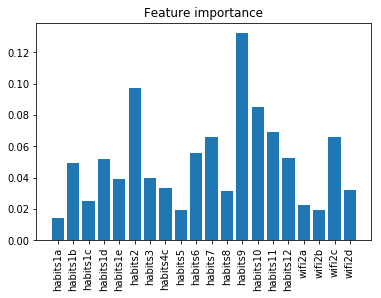

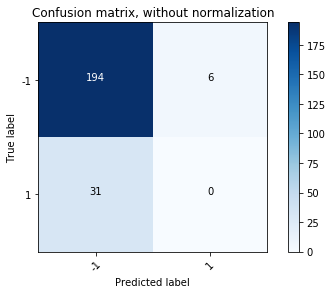


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 653, 1: 115}
	Classes in ytest: {-1: 218, 1: 38}
	Best Parameters: {'min_samples_split': 7, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.77
	Metrics for train data
	Precision: 0.51
	Recall: 0.49
	F1 Score: 0.5
	Cohen's Kappa: 0.41


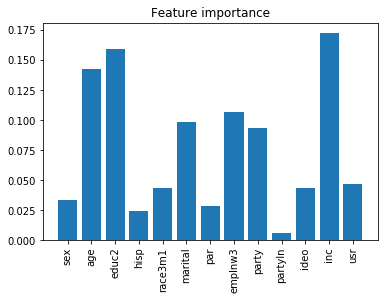

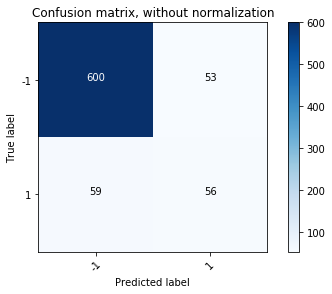

	Accuracy on training data: 0.85
	Accuracy on test data:     0.77
	Metrics for test data
	Precision: 0.14
	Recall: 0.11
	F1 Score: 0.12
	Cohen's Kappa: -0.01


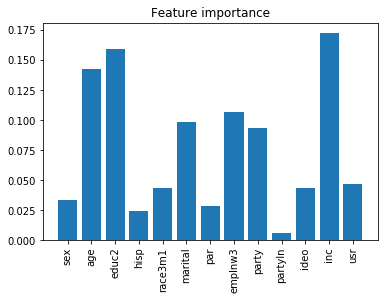

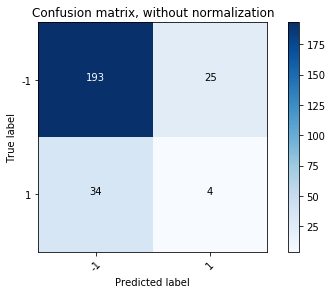


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 653, 1: 115}
	Classes in ytest: {-1: 218, 1: 38}
	Best Parameters: {'min_samples_split': 9, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.85
	Accuracy on test data:     0.76
	Metrics for train data
	Precision: 0.47
	Recall: 0.3
	F1 Score: 0.36
	Cohen's Kappa: 0.28


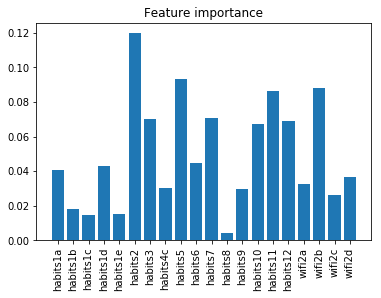

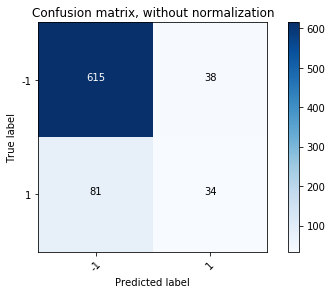

	Accuracy on training data: 0.85
	Accuracy on test data:     0.76
	Metrics for test data
	Precision: 0.13
	Recall: 0.11
	F1 Score: 0.12
	Cohen's Kappa: -0.02


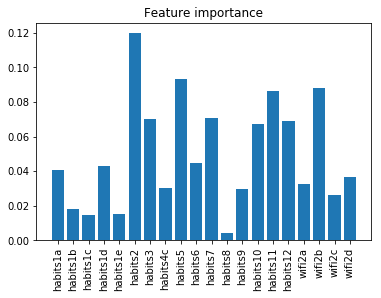

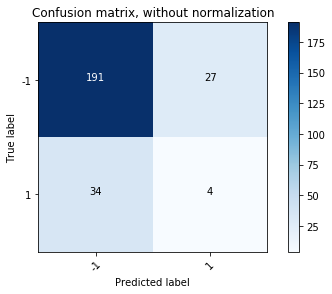


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 727, 1: 43}
	Classes in ytest: {-1: 243, 1: 14}
	Best Parameters: {'min_samples_split': 4, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.95
	Accuracy on test data:     0.93
	Metrics for train data
	Precision: 0.58
	Recall: 0.42
	F1 Score: 0.49
	Cohen's Kappa: 0.46


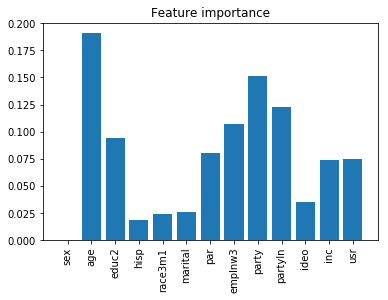

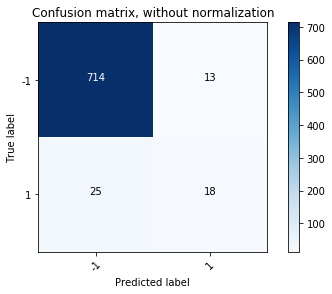

	Accuracy on training data: 0.95
	Accuracy on test data:     0.93
	Metrics for test data
	Precision: 0.29
	Recall: 0.14
	F1 Score: 0.19
	Cohen's Kappa: 0.16


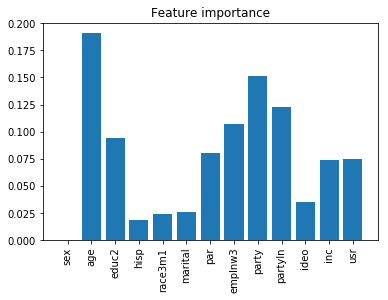

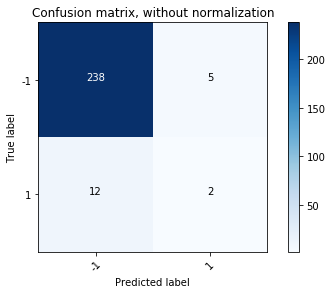


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 727, 1: 43}
	Classes in ytest: {-1: 243, 1: 14}
	Best Parameters: {'min_samples_split': 5, 'n_estimators': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.95
	Accuracy on test data:     0.94
	Metrics for train data
	Precision: 0.6
	Recall: 0.14
	F1 Score: 0.23
	Cohen's Kappa: 0.21


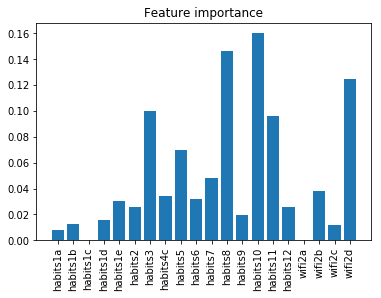

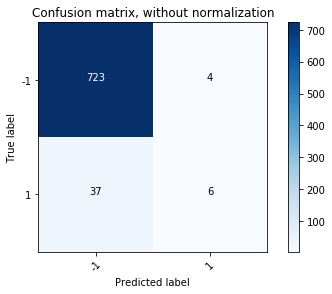

	Accuracy on training data: 0.95
	Accuracy on test data:     0.94
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.01


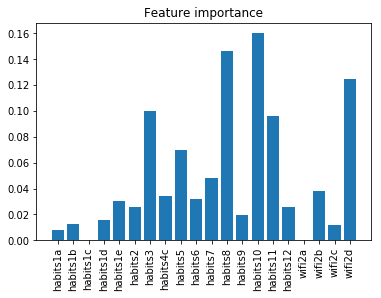

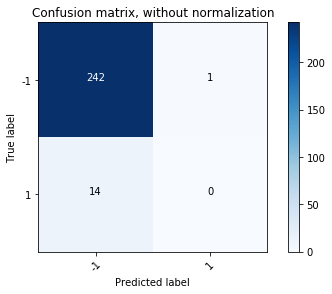

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf_str = 'RF'
mod_results = []

dict_params = {'n_estimators': [1, 5, 10, 15, 20, 25, 30],
               'min_samples_split': [3, 4, 5, 6, 7, 8, 9, 10, 20]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        # remove ID from dem_cols
        x_cols = dem_cols[:]
        x_cols.remove('ID')
        
        """ ======= PERFORM RANDOM FOREST W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """
    
        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        clf, Xtrain, ytrain, Xtest, ytest, mod_results = do_classify(clf=RandomForestClassifier(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results = mod_results,
                                                                     clf_str=clf_str)
        
        # remove ID from hab_cols
        x_cols = hab_cols[:]
        x_cols.remove('ID')
        
        """ ======= PERFORM RANDOM FOREST W/ SECURITY HABITS VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest, mod_results = do_classify(clf=RandomForestClassifier(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results = mod_results,
                                                                     clf_str=clf_str)
        
        curr_mod_results = pd.DataFrame(mod_results) 

# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()

df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>SVC</h1>
</div>

SVC models represent data as points in space, mapped so that the data of the different categories are divided by a gap that's as wide as possible 
* C: parameter for slack variables; trades off misclassification of training examples against simplicity of decision surface (low values = allows more slack, ensures hyperplane won't change dramatically for outliers)
* Gamma: how far the influence of a single training sample reaches (low values = 'far')


Y = SECUR2A (SSN compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 650, 1: 125}
	Classes in ytest: {-1: 217, 1: 42}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.84
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


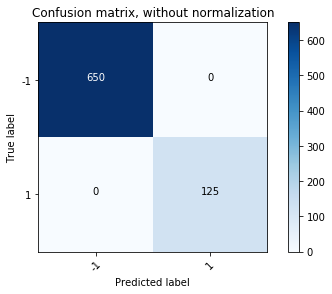

	Accuracy on training data: 1.00
	Accuracy on test data:     0.84
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


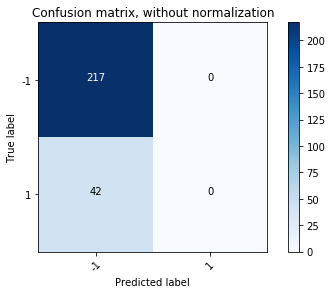


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 650, 1: 125}
	Classes in ytest: {-1: 217, 1: 42}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1.2589254117941673}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.84
	Metrics for train data
	Precision: 1.0
	Recall: 0.87
	F1 Score: 0.93
	Cohen's Kappa: 0.92


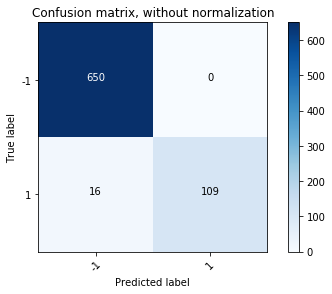

	Accuracy on training data: 0.98
	Accuracy on test data:     0.84
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


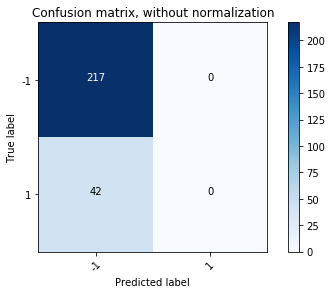


Y = SECUR2B (Other sensitive info compromised)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 471, 1: 301}
	Classes in ytest: {-1: 157, 1: 101}
	Best Parameters: {'C': 1, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.61
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


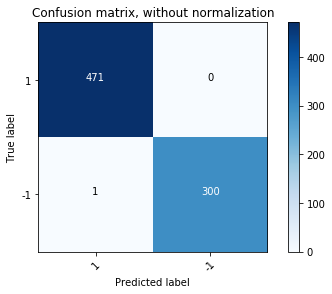

	Accuracy on training data: 1.00
	Accuracy on test data:     0.61
	Metrics for test data
	Precision: 1.0
	Recall: 0.01
	F1 Score: 0.02
	Cohen's Kappa: 0.01


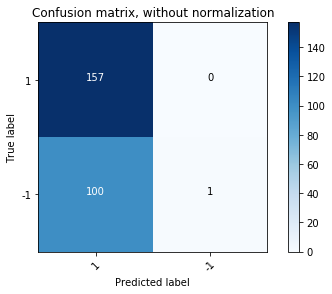


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 471, 1: 301}
	Classes in ytest: {-1: 157, 1: 101}
	Best Parameters: {'C': 10, 'gamma': 1.2589254117941673}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.96
	Accuracy on test data:     0.60
	Metrics for train data
	Precision: 1.0
	Recall: 0.9
	F1 Score: 0.95
	Cohen's Kappa: 0.92


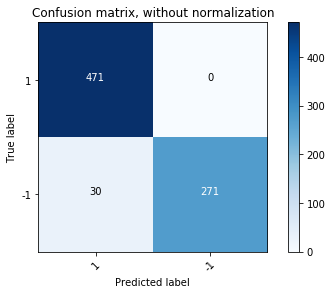

	Accuracy on training data: 0.96
	Accuracy on test data:     0.60
	Metrics for test data
	Precision: 0.33
	Recall: 0.03
	F1 Score: 0.05
	Cohen's Kappa: -0.01


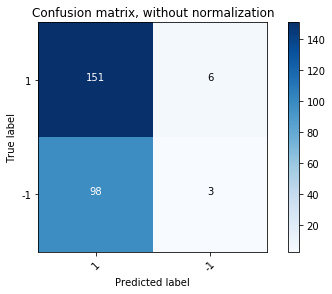


Y = SECUR2C (Fraudulent charges on credit/debit card)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 421, 1: 356}
	Classes in ytest: {-1: 140, 1: 119}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1.2589254117941673}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.53
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


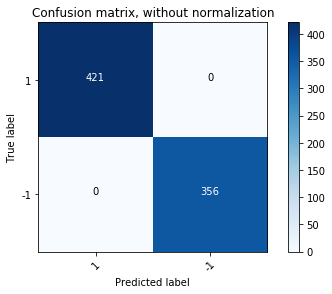

	Accuracy on training data: 1.00
	Accuracy on test data:     0.53
	Metrics for test data
	Precision: 0.33
	Recall: 0.02
	F1 Score: 0.03
	Cohen's Kappa: -0.01


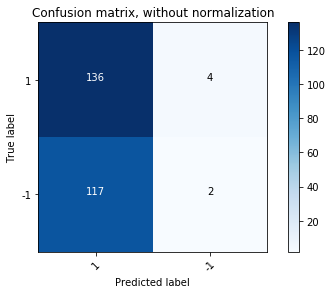


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 421, 1: 356}
	Classes in ytest: {-1: 140, 1: 119}
	Best Parameters: {'C': 10, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.95
	Accuracy on test data:     0.53
	Metrics for train data
	Precision: 0.98
	Recall: 0.92
	F1 Score: 0.95
	Cohen's Kappa: 0.91


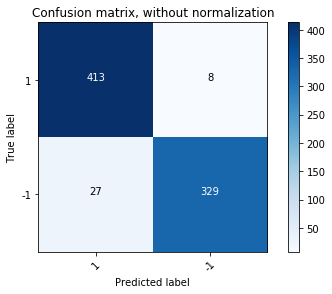

	Accuracy on training data: 0.95
	Accuracy on test data:     0.53
	Metrics for test data
	Precision: 0.47
	Recall: 0.3
	F1 Score: 0.37
	Cohen's Kappa: 0.02


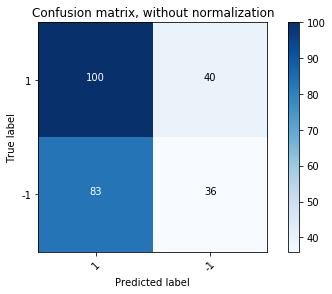


Y = SECUR2D (Someone took over email)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 641, 1: 131}
	Classes in ytest: {-1: 214, 1: 44}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.83
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


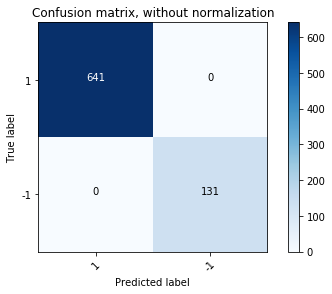

	Accuracy on training data: 1.00
	Accuracy on test data:     0.83
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


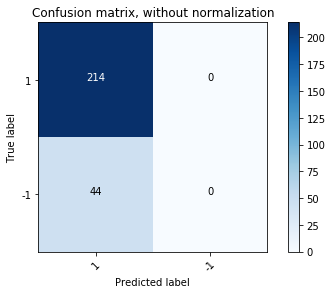


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 641, 1: 131}
	Classes in ytest: {-1: 214, 1: 44}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.99
	Accuracy on test data:     0.83
	Metrics for train data
	Precision: 1.0
	Recall: 0.96
	F1 Score: 0.98
	Cohen's Kappa: 0.98


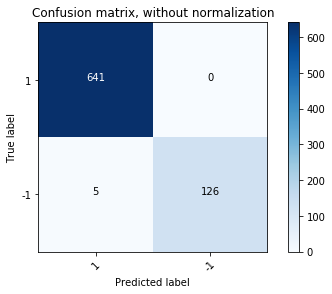

	Accuracy on training data: 0.99
	Accuracy on test data:     0.83
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


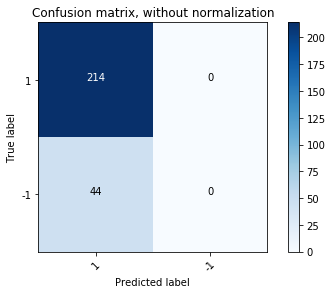


Y = SECUR2E (Someone took over social media account)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 598, 1: 92}
	Classes in ytest: {-1: 200, 1: 31}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.87
	Metrics for train data
	Precision: 1.0
	Recall: 0.99
	F1 Score: 0.99
	Cohen's Kappa: 0.99


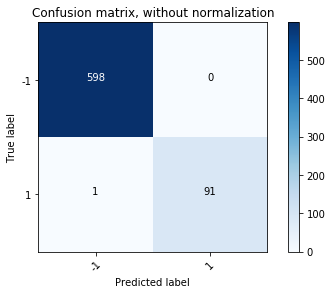

	Accuracy on training data: 1.00
	Accuracy on test data:     0.87
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


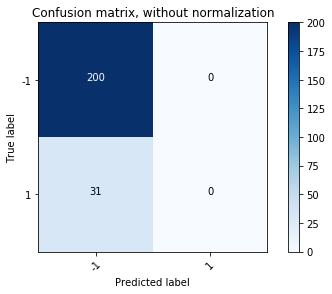


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 598, 1: 92}
	Classes in ytest: {-1: 200, 1: 31}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.87
	Metrics for train data
	Precision: 1.0
	Recall: 0.97
	F1 Score: 0.98
	Cohen's Kappa: 0.98


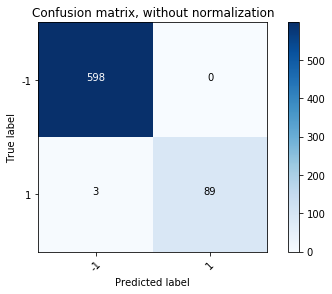

	Accuracy on training data: 1.00
	Accuracy on test data:     0.87
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


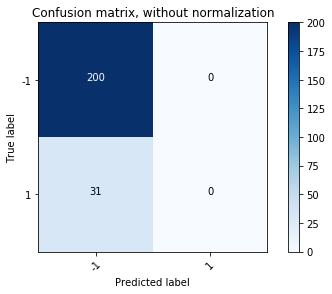


Y = SECUR2F (Someone opened line of credit/applied for loan under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 653, 1: 115}
	Classes in ytest: {-1: 218, 1: 38}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.85
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


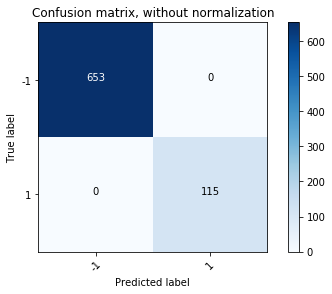

	Accuracy on training data: 1.00
	Accuracy on test data:     0.85
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


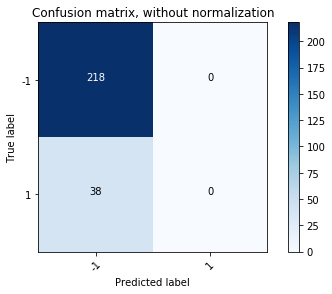


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 653, 1: 115}
	Classes in ytest: {-1: 218, 1: 38}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.97
	Accuracy on test data:     0.85
	Metrics for train data
	Precision: 1.0
	Recall: 0.79
	F1 Score: 0.88
	Cohen's Kappa: 0.87


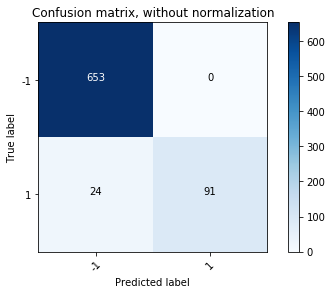

	Accuracy on training data: 0.97
	Accuracy on test data:     0.85
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: -0.01


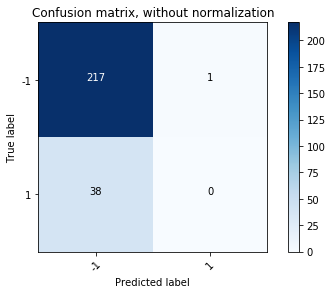


Y = SECUR2G (Someone received tax refund under name)

	X = DEMOGRAPHIC VARIABLES
	Classes in ytrain: {-1: 727, 1: 43}
	Classes in ytest: {-1: 243, 1: 14}
	Best Parameters: {'C': 1.2589254117941673, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 1.00
	Accuracy on test data:     0.95
	Metrics for train data
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0
	Cohen's Kappa: 1.0


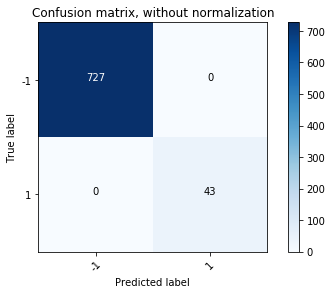

	Accuracy on training data: 1.00
	Accuracy on test data:     0.95
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


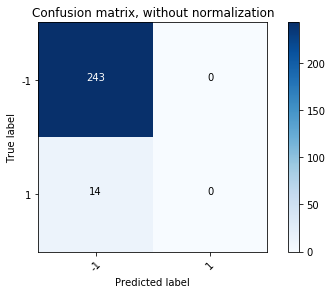


	X = SECURITY HABIT VARIABLES
	Classes in ytrain: {-1: 727, 1: 43}
	Classes in ytest: {-1: 243, 1: 14}
	Best Parameters: {'C': 1, 'gamma': 1}
	Scoring method used: make_scorer(cohen_kappa_score))
	Accuracy on training data: 0.98
	Accuracy on test data:     0.95
	Metrics for train data
	Precision: 1.0
	Recall: 0.56
	F1 Score: 0.72
	Cohen's Kappa: 0.7


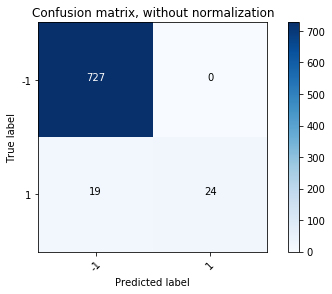

	Accuracy on training data: 0.98
	Accuracy on test data:     0.95
	Metrics for test data
	Precision: 0.0
	Recall: 0.0
	F1 Score: 0.0
	Cohen's Kappa: 0.0


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


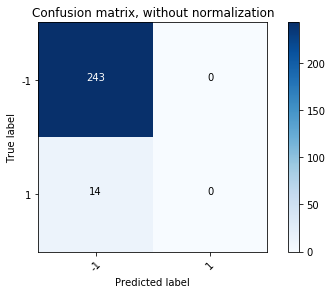

In [30]:
from sklearn.svm import SVC

clf_str = 'SVC'
mod_results = []

# create dictionary of parameters
dict_params = {'C': [10**0.1, 10**0, 10**1],
               'gamma': [10**0, 10**0.1, 10**1]}

# set scoring method for cv_optimize (Cohen's Kappa)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

""" ======= ITERATE THROUGH SECURITY INCIDENT COLUMNS ======= """
for y_col in sec_cols:

    if y_col != 'ID':
        
        print('\nY = ' + y_col.upper() + ' (' + dict_sec_cols[y_col] + ')')
        
        # remove rows where y_col is don't know/refused (0)
        clf_df = df[df[y_col] != 0]        
        
        # remove ID from dem_cols
        x_cols = dem_cols[:]
        x_cols.remove('ID')
        
        """ ======= PERFORM SVM W/ DEMOGRAPHIC VARIABLES AS FEATURES ======= """
        
        print('\n\tX = DEMOGRAPHIC VARIABLES') 
        clf, Xtrain, ytrain, Xtest, ytest, mod_results = do_classify(clf=SVC(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results = mod_results,
                                                                     clf_str=clf_str)
        
        # remove ID from hab_cols
        x_cols = hab_cols[:]
        x_cols.remove('ID')
        
        """ ======= PERFORM SVM W/ SECURITY HABITS VARIABLES AS FEATURES ======= """
        
        print('\n\tX = SECURITY HABIT VARIABLES')
        clf, Xtrain, ytrain, Xtest, ytest, mod_results = do_classify(clf=SVC(), 
                                                         parameters=dict_params, 
                                                         df=clf_df,
                                                         feature_names=x_cols,
                                                         targetname=y_col,
                                                         target1val=1,
                                                         standardize=False,
                                                         scorer=scorer,
                                                         strat=True,
                                                         mod_results = mod_results,
                                                                     clf_str=clf_str)

        curr_mod_results = pd.DataFrame(mod_results) 

# rearrange results column order
curr_mod_results = reorder_cols(curr_mod_results)

# add results to final results dataframe
if 'df_mod_results' not in locals(): df_mod_results = create_final_df()

df_mod_results = df_mod_results.append(curr_mod_results)

<div class="alert alert-success">
<h1>FINAL MODEL RESULTS</h1>
</div>

In [31]:
for key, val in dict_sec_cols.items():
    print(key,val)

secur2a SSN compromised
secur2b Other sensitive info compromised
secur2c Fraudulent charges on credit/debit card
secur2d Someone took over email
secur2e Someone took over social media account
secur2f Someone opened line of credit/applied for loan under name
secur2g Someone received tax refund under name


In [32]:
pd.set_option('display.max_rows', 100)
df_mod_results

,y,X,clf,best_params,score_meth,acc_train,precision_train,recall_train,f1_train,cohenk_train,acc_test,precision_test,recall_test,f1_test,cohenk_test
0,secur2a,dem_vars,logreg,"{'C': 10, 'class_weight': {0: 0.2, 1: 0.8}, 'f...",cohenk,0.70,0.22,0.34,0.27,0.09,0.67,0.21,0.36,0.26,0.07
1,secur2a,hab_cols,logreg,"{'C': 0.001, 'class_weight': {0: 0.2, 1: 0.8},...",cohenk,0.80,0.32,0.21,0.25,0.14,0.76,0.19,0.14,0.16,0.03
2,secur2b,dem_vars,logreg,"{'C': 0.1, 'class_weight': {0: 0.4, 1: 0.6}, '...",cohenk,0.62,0.51,0.61,0.55,0.22,0.56,0.45,0.56,0.50,0.11
3,secur2b,hab_cols,logreg,"{'C': 1, 'class_weight': {0: 0.4, 1: 0.6}, 'fi...",cohenk,0.63,0.53,0.61,0.56,0.25,0.60,0.50,0.59,0.54,0.20
4,secur2c,dem_vars,logreg,"{'C': 10, 'class_weight': {0: 0.4, 1: 0.6}, 'f...",cohenk,0.62,0.56,0.78,0.65,0.25,0.59,0.54,0.75,0.63,0.21
5,secur2c,hab_cols,logreg,"{'C': 0.01, 'class_weight': {0: 0.4, 1: 0.6}, ...",cohenk,0.59,0.54,0.83,0.65,0.21,0.58,0.53,0.84,0.65,0.20
6,secur2d,dem_vars,logreg,"{'C': 0.1, 'class_weight': {0: 0.2, 1: 0.8}, '...",cohenk,0.70,0.27,0.44,0.33,0.16,0.69,0.25,0.41,0.31,0.12
7,secur2d,hab_cols,logreg,"{'C': 0.01, 'class_weight': {0: 0.2, 1: 0.8}, ...",cohenk,0.66,0.26,0.54,0.35,0.16,0.71,0.31,0.57,0.40,0.23
8,secur2e,dem_vars,logreg,"{'C': 1, 'class_weight': {0: 0.2, 1: 0.8}, 'fi...",cohenk,0.79,0.27,0.33,0.29,0.17,0.78,0.19,0.19,0.19,0.06
9,secur2e,hab_cols,logreg,"{'C': 0.1, 'class_weight': {0: 0.2, 1: 0.8}, '...",cohenk,0.80,0.28,0.33,0.30,0.18,0.80,0.24,0.23,0.23,0.12


## Save results

In [ ]:
import os 

path = '/Users/Rachel/Desktop'
filename = 'df_mod_results_26Sep17.txt'
fullpath = os.path.join(path, filename)
df_mod_results.to_csv(fullpath, sep='\t', encoding='utf-8', index = False)